In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import ADASYN
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from CHAID import Tree
from optbinning import OptimalBinning
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor

from hyperopt import fmin, hp, tpe, Trials
from hyperopt.pyll.base import scope
from functools import partial
from hyperopt import base
base.have_bson = False

(CVXPY) Apr 22 06:40:11 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 22 06:40:11 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [109]:
pd.set_option('display.max_columns', 95)
df = pd.read_csv('_BANKRUPTCY PREDICTION .csv')

In [64]:
df.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan �,Operating Profit Per Share (Yuan �,Per Share Net profit before tax (Yuan �,Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.22

In [9]:
print(df['Bankrupt'].value_counts())
print('-'* 30)
print('Financially stable: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Financially unstable: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

0    6599
1     220
Name: Bankrupt, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


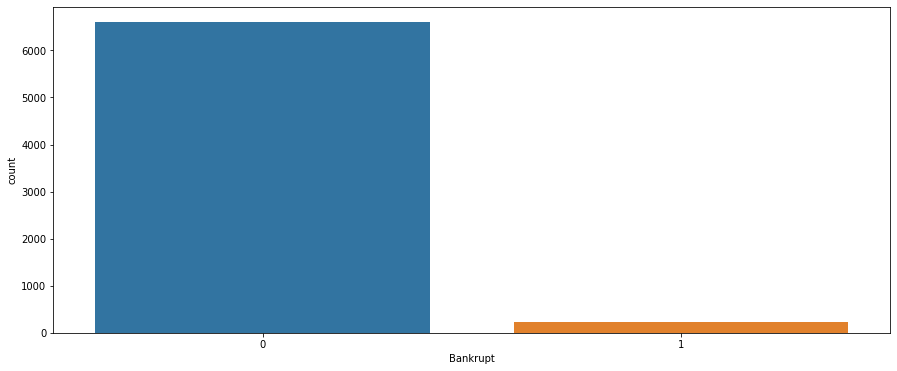

In [7]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Bankrupt')
plt.savefig('bankrupt_countplot.png')
plt.show()

In [110]:
c = df.corr()
c

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan �,Operating Profit Per Share (Yuan �,Per Share Net profit before tax (Yuan �,Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
ROA(C) before interest and depreciation before interest,1.000000,0.940124,0.986849,0.334719,0.332755,0.035725,0.053419,0.049222,0.020501,0.051328,0.066869,0.106461,0.323482,0.048882,0.250761,0.505580,0.505407,0.505281,0.775006,0.379839,-0.015932,0.687201,0.750564,0.000591,0.036511,0.115083,0.115040,0.025234,0.019635,-0.021930,0.079906,0.296158,0.013196,-0.026336,0.003988,-0.022208,-0.261427,0.261427,0.002967,-0.161671,-0.035729,0.685028,0.753339,-0.109888,0.210622,-0.033947,0.007019,-0.062660,-0.065919,0.022896,-0.014834,0.301996,-0.012543,0.259680,0.181993,0.098820,0.235314,-0.010530,-0.046009,-0.210256,0.388151,-0.004447,0.013330,0.052783,0.103819,-0.142734,0.021508,0.650217,0.023450,-0.296019,0.005716,-0.027280,0.001824,-0.029477,0.011759,-0.009192,0.052783,-0.142734,-0.086535,0.262454,0.159699,0.504311,0.129002,-0.160725,-0.109272,0.887670,-0.071725,0.008135,0.334721,0.274287,-0.143629,-0.016575,0.010573,0.052416,-0.260807
ROA(A) before interest and % after tax,0.940124,1.000000,0.955741,0.326969,0.324956,0.032053,0.053518,0.049474,0.029649,0.049909,0.075727,0.084334,0.288440,0.050362,0.225897,0.531799,0.531790,0.531821,0.764828,0.326239,-0.011829,0.654253,0.752578,0.003277,0.042208,0.125384,0.125872,0.024887,0.026977,-0.063970,0.081982,0.263615,0.014102,-0.018412,0.005440,-0.010323,-0.259972,0.259972,0.020707,-0.161868,-0.0361

In [122]:
df[' Current Liability to Liability']

0       0.676269
1       0.308589
2       0.446027
3       0.615848
4       0.975007
          ...   
6814    0.786888
6815    0.849898
6816    0.553964
6817    0.893241
6818    1.000000
Name:  Current Liability to Liability, Length: 6819, dtype: float64

In [ ]:
df.drop([' Current Liability to Liability', ' Current Liabilities to Equity', ' Net worth/Assets', ' Gross Profit to Sales', ' Net Value Per Share (C)', ' Realized Sales Gross Margin'])

In [126]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool')).stack().sort_values(ascending=False)
upper[:10]

 Debt ratio %                                              Net worth/Assets                                     1.000000
 Net Value Per Share (A)                                   Net Value Per Share (C)                              0.999837
 Operating Gross Margin                                    Realized Sales Gross Margin                          0.999518
 Net Value Per Share (B)                                   Net Value Per Share (A)                              0.999342
                                                           Net Value Per Share (C)                              0.999179
 After-tax Net Profit Growth Rate                          Regular Net Profit Growth Rate                       0.996186
 ROA(C) before interest and depreciation before interest   ROA(B) before interest and depreciation after tax    0.986849
 Pre-tax net Interest Rate                                 After-tax net Interest Rate                          0.986379
 ROA(A) before interest and % af

In [124]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=4).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
to_drop

[' Continuous interest rate (after tax)',
 ' Per Share Net profit before tax (Yuan �',
 ' Operating profit/Paid-in capital',
 ' Net profit before tax/Paid-in capital',
 ' Current Liability to Liability',
 ' Current Liability to Equity',
 ' Net Income to Total Assets',
 ' Gross Profit to Sales',
 ' Liability to Equity']

In [125]:
df.drop(to_drop, axis=1, inplace=True)

In [265]:
X = df.drop('Bankrupt', axis=1)

sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
sel.fit(X)
X[X.columns[sel.get_support(indices=True)]]

,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Revenue Per Share (Yuan �,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Total debt/Total net worth,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Revenue per person,Allocation rate per person,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Total assets to GNP price
0,1.256970e-04,0.000000e+00,7.250730e-04,0.017560,4.980000e+09,0.000327,0.002259,0.001208,0.021266,0.001814,0.003487,1.820930e-04,1.165010e-04,0.034164,0.037135,0.001997,1.473360e-04,0.001036,2.559237e-02,7.010000e+08,6.550000e+09,4.580000e+08,0.424206,0.009219
1,2.897850e-04,0.000000e+00,6.470650e-04,0.021144,6.110000e+09,0.000443,0.006016,0.004039,0.012502,0.001286,0.004917,9.360000e+09,7.190000e+08,0.006889,0.012335,0.004136,1.383910e-03,0.005210,2.394682e-02,1.065200e-04,7.700000e+09,2.490000e+09,0.468828,0.008323
2,2.361300e-04,2.550000e+07,7.900790e-04,0.005944,7.280000e+09,0.000396,0.011543,0.005348,0.021248,0.001495,0.004227,6.500000e+07,2.650000e+09,0.028997,0.141016,0.006302,5.340000e+09,0.013879,3.715116e-03,1.791094e-03,1.022676e-03,7.610000e+08,0.276179,0.040003
3,1.078890e-04,0.000000e+00,4.490450e-04,0.014368,4.880000e+09,0.000382,0.004194,0.002896,0.009572,0.001966,0.003215,7.130000e+09,9.150000e+09,0.015463,0.021320,0.002961,1.010646e-03,0.003540,2.216520e-02,8.140000e+09,6.050000e+09,2.030000e+09,0.559144,0.003252
4,7.890000e+09,0.000000e+00,6.860690e-04,0.029690,5.510000e+09,0.000439,0.006022,0.003727,0.005150,0.001449,0.004367,1.633670e-04,2.935210e-04,0.058111,0.023988,0.004275,6.804640e-04,0.004869,0.000000e+00,6.680000e+09,5.050000e+09,8.240000e+08,0.309555,0.003878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,1.510210e-04,4.500000e+09,1.790180e-04,0.020766,7.070000e+09,0.000450,0.010451,0.005457,0.006655,0.000690,0.009177,4.030000e+07,1.429780e-04,0.006348,0.006312,0.005469,5.071548e-03,0.013212,1.792237e-03,2.294150e-04,1.244230e-04,1.077940e-04,0.400338,0.000466
6815,5.220000e+09,1.440000e+09,2.370240e-04,0.023050,5.220000e+09,0.000445,0.009259,0.006741,0.004623,0.000655,0.009652,9.940000e+09,6.051980e-04,0.016083,0.003401,0.006790,4.727181e-03,0.006730,2.204673e-03,1.517300e-04,1.173400e-04,7.710000e+09,0.096136,0.001959
6816,2.509310e-04,1.039090e-04,0.000000e+00,0.044255,5.990000e+09,0.000435,0.038424,0.035112,0.001392,0.001510,0.004188,2.797310e-04,1.024298e-03,0.022097,0.002774,0.035531,8.821248e-02,0.007810,0.000000e+00,1.762270e-04,1.749710e-04,4.074260e-04,0.055509,0.002840
6817,1.236150e-04,2.510000e+09,2.110210e-04,0.031535,7.250000e+09,0.000529,0.012782,0.007256,0.003816,0.000716,0.008829,4.550000e+09,2.330010e-04,0.012749,0.007489,0.007753,7.133218e-03,0.013334,3.200000e+09,2.135940e-04,1.351940e-04,1.165390e-04,0.246805,0.002837


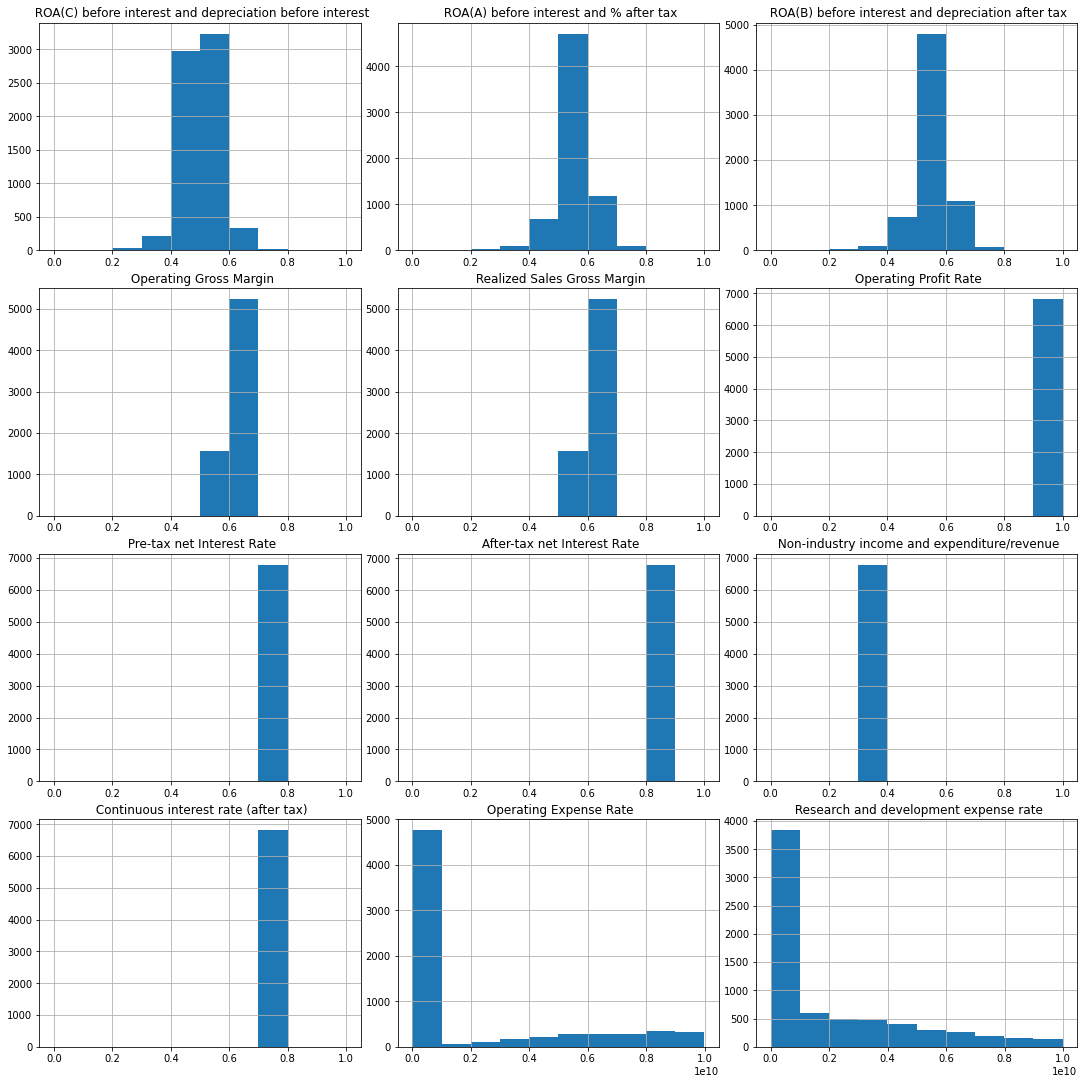

In [17]:
df.loc[:, df.columns[:12]].hist(figsize=(15, 15))
plt.tight_layout(pad=0.5)
plt.savefig('histogram_of_independent_variables_1.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 15))
sns.pairplot(data=df, hue='Bankrupt')
plt.savefig('pairplot.png')
plt.show()

KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

Error in callback <function flush_figures at 0x000001F2CA122E60> (for post_execute):


In [52]:
X = df.drop('Bankrupt', axis=1)
X_mean = X.mean(axis=0)
var = np.var(X/X_mean)
top_30 = var.sort_values(ascending=False).head(30)
top_30

 Liability-Assets Flag                    851.375000
 Total income/Total expense                22.504532
 Long-term fund suitability ratio (A)      10.273631
 Fixed Assets Turnover Frequency            6.033221
 Current Asset Turnover Rate                5.564607
 Contingent liabilities/Net worth           4.169932
 Operating Expense Rate                     2.632499
 Quick Asset Turnover Rate                  2.432547
 Inventory Turnover Rate (times)            2.283725
 Long-term Liability to Current Assets      2.196953
 Total assets to GNP price                  2.128873
 Cash/Current Liability                     1.784464
 Research and development expense rate      1.774404
 Tax rate (A)                               1.453732
 Cash Turnover Rate                         1.412978
 Cash/Total Assets                          1.258997
 Equity to Liability                        1.104831
 Allocation rate per person                 1.095935
 Revenue per person                         1.

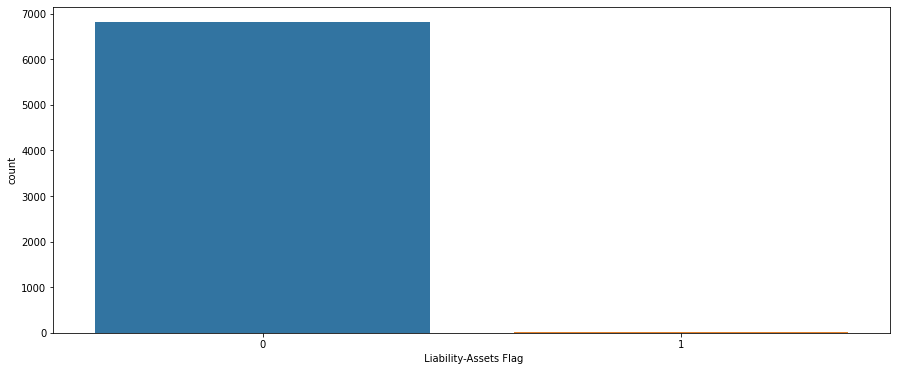

In [61]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x=' Liability-Assets Flag')
plt.savefig('liability_assets_flag_countplot.png')
plt.show()

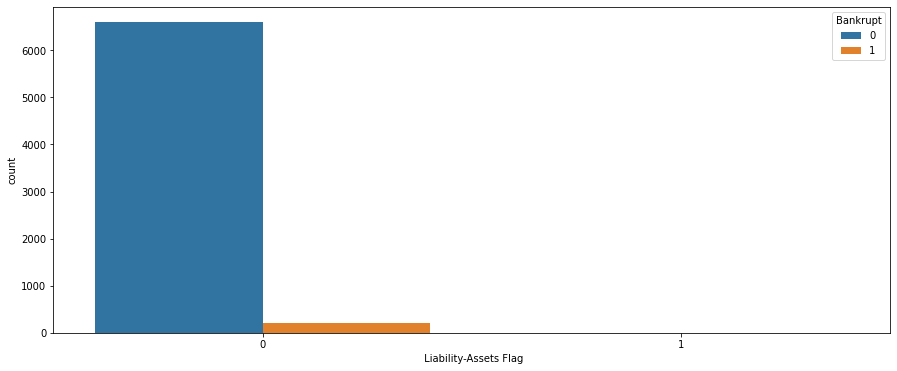

In [62]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x=' Liability-Assets Flag', hue='Bankrupt')
plt.savefig('liability_assets_flag_countplot_hue_bankrupt.png')
plt.show()

In [58]:
df[' Total income/Total expense'].nunique()

6789

In [268]:
top_19 = var.sort_values(ascending=False).head(19)
top_19

 Current Ratio                            6817.999489
 Fixed Assets to Assets                   6817.997213
 Net Value Growth Rate                    5312.004777
 Revenue per person                       3450.486394
 Quick Assets/Current Liability           2281.318433
 Revenue Per Share (Yuan �                1514.333244
 Total debt/Total net worth               1453.890641
 Quick Ratio                               853.129754
 Liability-Assets Flag                     851.375000
 Allocation rate per person                684.500651
 Average Collection Days                   680.550015
 Accounts Receivable Turnover              473.277969
 Total assets to GNP price                 408.274712
 Cash/Current Liability                    188.591801
 Long-term Liability to Current Assets     110.851196
 Inventory/Current Liability               108.763933
 Interest-bearing debt interest rate        43.327745
 Total income/Total expense                 22.504532
 Long-term fund suitability 

In [269]:
df[var.index].describe()

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan �,Operating Profit Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.505180,0.607948,0.998755,0.303623,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.228813,0.323482,1.328641e+06,0.109091,0.022408,0.847980,0.689146,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.008783,0.374654,0.005968,0.402459,0.141606,1.278971e+07,9.826221e+06,2.149106e+09,1.008596e+09,0.038595,2.325854e+06,0.400671,1.125579e+07,0.814125,0.400132,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,1.220121e+06,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,1.862942e+07,0.623915,0.840402,0.027541,0.565358,0.047578
std,0.060686,0.016934,0.013010,0.011163,3.237684e+09,2.598292e+09,0.017036,1.082750e+08,0.138667,0.033390,0.033263,0.017611,5.170709e+07,0.027942,0.012079,0.010752,0.013853,0.010063,2.897718e+09,1.141594e+08,0.009634,0

In [90]:
cols = df[[
    ' Revenue Per Share (Yuan �', ' Net Value Growth Rate', ' Current Ratio',
    ' Quick Ratio', ' Total debt/Total net worth', ' Accounts Receivable Turnover', ' Average Collection Days', 
    ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Revenue per person',
    ' Allocation rate per person', ' Quick Assets/Current Liability', ' Cash/Current Liability', 
    ' Inventory/Current Liability', ' Long-term Liability to Current Assets', ' Current Asset Turnover Rate',
    ' Fixed Assets to Assets', ' Total assets to GNP price']]

In [406]:
lst = cols.columns.tolist()
lst

[' Interest-bearing debt interest rate',
 ' Revenue Per Share (Yuan �',
 ' Net Value Growth Rate',
 ' Current Ratio',
 ' Quick Ratio',
 ' Total debt/Total net worth',
 ' Accounts Receivable Turnover',
 ' Average Collection Days',
 ' Inventory Turnover Rate (times)',
 ' Fixed Assets Turnover Frequency',
 ' Revenue per person',
 ' Allocation rate per person',
 ' Quick Assets/Current Liability',
 ' Cash/Current Liability',
 ' Inventory/Current Liability',
 ' Long-term Liability to Current Assets',
 ' Current Asset Turnover Rate',
 ' Fixed Assets to Assets',
 ' Total assets to GNP price']

In [407]:
df_copy = df.copy()

In [408]:
for col in df[lst]:
    df_copy.drop(df_copy.loc[df[col] > 1].index, axis=0, inplace=True)

In [410]:
df_copy

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Cash Flow Per Share,Revenue Per Share (Yuan �,Operating Profit Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
6,0.390923,0.619950,0.998993,0.302814,3.984830e-04,7.300000e+08,0.461020,0.000805,0.000000,0.158822,0.316687,0.030915,0.099910,0.022112,0.848322,0.688590,0.217604,5.720000e+09,0.000352,0.263032,0.375303,0.004672,0.002869,0.629988,0.024441,0.216102,0.005005,0.008044,0.400574,0.100450,0.001662,0.003805,0.000162,0.000145,0.040806,0.011460,0.393173,0.009703,0.729416,0.255093,0.022989,0.003974,0.001050,0.340081,0.276643,0.002159,0.508089,0.009347,0.911441,0.002121,0.092802,0.000106,9.560000e+09,0.593893,2.390000e+09,0.355854,0.120561,0.630419,0.457785,0.560653,0.310296,0.060765,0,0.018372,0.623655,0.829980,0.026622,0.564200,0.015663,0
8,0.488519,0.603612,0.998961,0.303584,1.687140e-04,0.000000e+00,0.463142,0.000737,0.005871,0.184189,0.318773,0.026604,0.095188,0.022128,0.848159,0.689924,0.217654,6.890000e+09,0.000453,0.264151,0.377994,0.013499,0.011823,0.630915,0.002266,0.058591,0.005418,0.005366,0.397462,0.154423,0.001303,0.004855,0.000304,0.000246,0.029516,0.016383,0.391940,0.008815,0.813738,0.378625,0.145189,0.011938,0.013190,0.345441,0.277087,0.004385,0.906707,0.000000,0.935200,0.002274,0.029884,0.000103,9.840000e+09,0.593959,1.052300e-04,0.323861,0.110933,0.649869,0.462165,0.574033,0.315376,0.021710,0,0.000824,0.623977,0.840487,0.026891,0.565592,0.065826,0
12,0.491152,0.608131,0.999045,0.303435,1.571500e-04,0.000000e+00,0.464100,0.000576,0.185241,0.169399,0.321214,0.024638,0.104877,0.022147,0.849688,0.689936,0.217656,7.220000e+09,0.000443,0.264405,0.381571,0.006631,0.004029,0.632378,0.008734,0.144662,0.005333,0.006553,0.400952,0.124438,0.001134,0.005575,0.000101,0.000214,0.033871,0.035325,0.401845,0.021017,0.760000,0.215492,0.058218,0.004089,0.003220,0.345787,0.278908,0.006916,0.624506,0.009513,0.930140,0.002273,0.028982,0.000108,6.910000e+09,0.593923,5.330000e+09,0.283666,0.116956,0.629827,0.456968,0.588644,0.312179,0.043514,0,0.008232,0.623578,0.840702,0.027480,0.567146,0.025282,0
21,0.504558,0.607446,0.999030,0.303531,1.609660e-04,1.190000e+09,0.470644,0.000775,0.208928,0.185454,0.327085,0.037872,0.107402,0.022080,0.848078,0.689529,0.217614,6.5

In [158]:
df[top_19.index].describe()

,Current Ratio,Fixed Assets to Assets,Net Value Growth Rate,Revenue per person,Quick Assets/Current Liability,Revenue Per Share (Yuan �,Total debt/Total net worth,Quick Ratio,Liability-Assets Flag,Allocation rate per person,Average Collection Days,Accounts Receivable Turnover,Total assets to GNP price,Cash/Current Liability,Long-term Liability to Current Assets,Inventory/Current Liability,Interest-bearing debt interest rate,Total income/Total expense,Long-term fund suitability ratio (A)
count,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000,6281.000000
mean,0.014437,0.254304,0.000543,0.034838,0.011298,0.039234,0.007860,0.010604,0.000796,0.015330,0.006941,0.001553,0.008597,0.012442,0.007065,0.008455,0.000828,0.002400,0.008144
std,0.013739,0.199396,0.002015,0.054737,0.012488,0.044189,0.019102,0.012010,0.028205,0.036505,0.003831,0.002927,0.033736,0.025912,0.014094,0.010878,0.017060,0.000544,0.021556
min,0.000193,0.000000,0.000000,0.000000,0.000132,0.000000,0.000111,0.000100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000772,0.004129
25%,0.007566,0.091015,0.000441,0.010522,0.005231,0.015866,0.003090,0.004684,0.000000,0.004259,0.004369,0.000710,0.000904,0.001907,0.000000,0.003123,0.000199,0.002236,0.005236
50%,0.010532,0.203749,0.000462,0.018448,0.007812,0.027512,0.005619,0.007292,0.000000,0.007949,0.006525,0.000968,0.002068,0.004756,0.002049,0.006345,0.000312,0.002334,0.005634
75%,0.016074,0.378282,0.000499,0.035374,0.012604,0.046387,0.009298,0.011978,0.000000,0.014789,0.008906,0.001445,0.005196,0.012124,0.008692,0.010642,0.000496,0.002485,0.006734
max,0.282589,0.998725,0.138678,1.000000,0.275000,0.993285,1.000000,0.272800,1.000000,1.000000,0.048165,0.057724,1.000000,0.738106,0.295417,0.329514,1.000000,0.021153,1.000000


In [278]:
columns = df[var.index].columns.tolist()

for col in columns:
    index_values = df[df[col] > 1].index
    percent = (len(index_values) / df.shape[0]) * 100
    print(f"Index values where {col}\n is greater than 1: {index_values}\n percentage of rows: {percent}\n\n\n")

Index values where  ROA(C) before interest and depreciation before interest
 is greater than 1: Int64Index([], dtype='int64')
 percentage of rows: 0.0



Index values where  Operating Gross Margin
 is greater than 1: Int64Index([], dtype='int64')
 percentage of rows: 0.0



Index values where  Operating Profit Rate
 is greater than 1: Int64Index([], dtype='int64')
 percentage of rows: 0.0



Index values where  Non-industry income and expenditure/revenue
 is greater than 1: Int64Index([], dtype='int64')
 percentage of rows: 0.0



Index values where  Operating Expense Rate
 is greater than 1: Int64Index([   4,    7,    9,   14,   18,   24,   29,   32,   34,   39,
            ...
            6769, 6784, 6791, 6792, 6795, 6796, 6804, 6805, 6810, 6815],
           dtype='int64', length=2282)
 percentage of rows: 33.465317495233904



Index values where  Research and development expense rate
 is greater than 1: Int64Index([   2,    6,    7,   10,   11,   13,   15,   16,   18,   20,
       

In [102]:
cols = df[[' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan �', 
                ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
                ' Total debt/Total net worth', ' Accounts Receivable Turnover', 
                ' Average Collection Days', ' Revenue per person', 
                ' Allocation rate per person', ' Quick Assets/Current Liability', 
                ' Cash/Current Liability', ' Inventory/Current Liability', 
                ' Long-term Liability to Current Assets',
                ' Fixed Assets to Assets', ' Total assets to GNP price']]

Interest-bearing debt interest rate, Revenue Per Share (Yuan �, Net Value Growth Rate, Current Ratio, Quick Ratio, Total debt/Total net worth, Accounts Receivable Turnover, Average Collection Days, Revenue per person, Allocation rate per person, Quick Assets/Current Liability, Cash/Current Liability, Inventory/Current Liability, Long-term Liability to Current Assets, Fixed Assets to Assets, Total assets to GNP price.

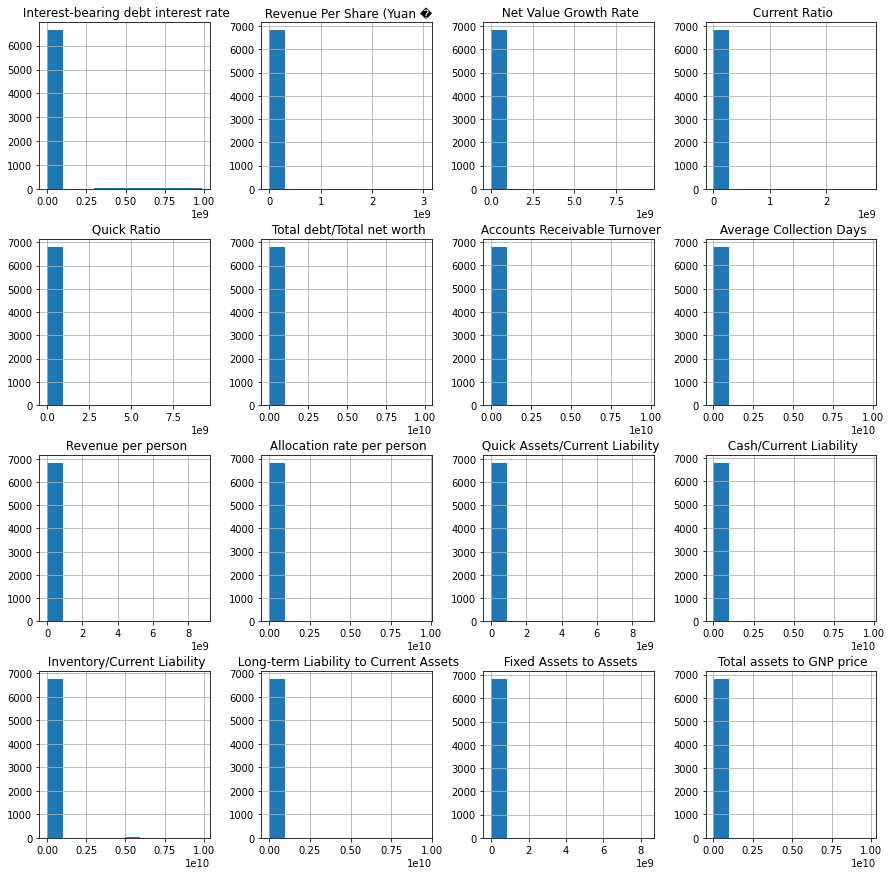

In [43]:
cols.hist(figsize=(15, 15))
plt.savefig('histogram_cols_before_winsorization.png')
plt.show()

In [103]:
for col in cols:
    df.loc[:, col] = winsorize(df[col], limits=(0.0, 0.05))

In [45]:
col = [' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan �', 
                ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio',
                ' Total debt/Total net worth', ' Accounts Receivable Turnover', 
                ' Average Collection Days', ' Revenue per person', 
                ' Allocation rate per person', ' Quick Assets/Current Liability', 
                ' Cash/Current Liability', ' Inventory/Current Liability', 
                ' Long-term Liability to Current Assets',
                ' Fixed Assets to Assets', ' Total assets to GNP price']

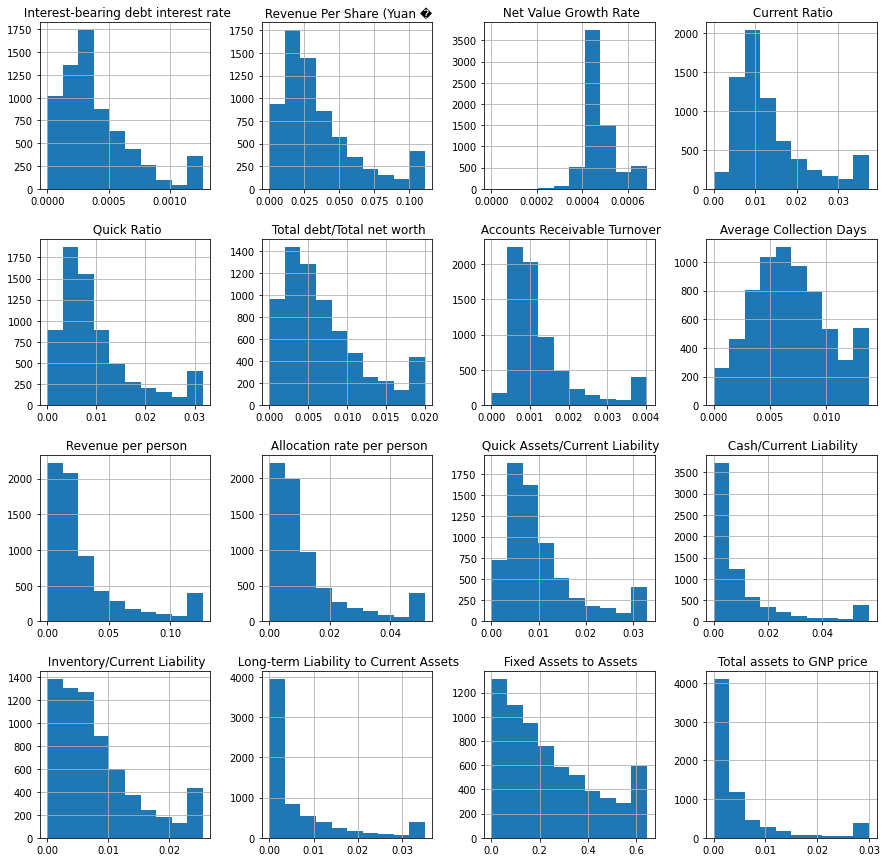

In [50]:
df[col].hist(figsize=(15, 15))
plt.savefig('histogram_cols_after_winsorization.png')
plt.show()

In [415]:
for col in cols:
    df_copy.drop(df_copy.loc[df[col] > 1].index, axis=0, inplace=True)

In [30]:
df_copy.shape

NameError: name 'df_copy' is not defined

In [31]:
df[' Net Value Growth Rate'].describe()

count    6819.000000
mean        0.000482
std         0.000070
min         0.000392
25%         0.000441
50%         0.000462
75%         0.000499
max         0.000683
Name:  Net Value Growth Rate, dtype: float64

<AxesSubplot:>

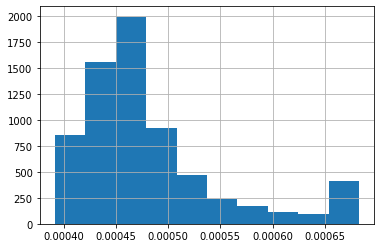

In [32]:
df[' Net Value Growth Rate'].hist()

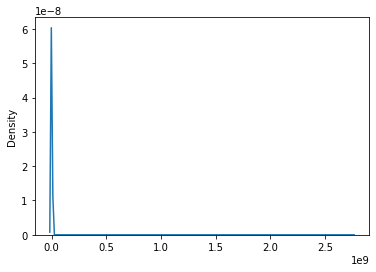

In [23]:
sns.kdeplot(winsorize((df[' Current Ratio']), limits=(0.01, 0.0)))
plt.show()

In [399]:
df[df[' Interest-bearing debt interest rate'] == 0]

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Cash Flow Per Share,Revenue Per Share (Yuan �,Operating Profit Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt
20,0.485253,0.622177,0.999065,0.303554,3.630990e-04,1.040000e+09,0.488241,0.0,0.261059,0.189120,0.322947,0.012266,0.101213,0.022065,0.848008,0.689330,0.217582,6.460000e+09,0.000446,0.263910,0.379382,0.026719,0.022853,0.630624,0.004425,0.096351,0.005329,0.005366,0.394905,0.053973,0.001816,0.003484,0.000142,9.000000e+09,0.017581,0.018295,0.398318,0.026512,0.789153,0.157050,0.031924,0.023000,0.013033,0.350829,0.277068,0.009948,0.112002,0.0,0.939765,0.002293,0.023529,1.282240e-04,1.189630e-04,0.593990,6.460000e+09,0.312308,0.110933,0.626864,0.455091,0.596802,0.312340,0.010941,0,0.014039,0.623922,0.840639,0.026794,0.565171,0.039507,0
45,0.488958,0.624317,0.999098,0.303529,3.628670e-04,1.100000e+09,0.487183,0.0,0.216621,0.187097,0.321921,0.011616,0.102679,0.022102,0.848074,0.689482,0.217605,6.440000e+09,0.000449,0.264050,0.378749,0.021259,0.017749,0.630617,0.004282,0.094235,0.005343,0.005366,0.394960,0.052474,0.001788,0.003537,0.000165,8.930000e+09,0.017419,0.019021,0.400658,0.027544,0.775479,0.105126,0.008048,0.017905,0.003746,0.349408,0.277089,0.009008,0.098633,0.0,0.940555,0.002308,0.023460,8.630000e+09,7.930000e+09,0.593964,1.650000e+09,0.308787,0.110933,0.631973,0.456360,0.591718,0.313064,0.013788,0,0.012883,0.623855,0.840771,0.026792,0.565164,0.040450,0
72,0.488812,0.623986,0.999043,0.303662,4.120130e-04,1.580000e+09,0.485863,0.0,0.281101,0.187055,0.323477,0.010330,0.099178,0.022091,0.848002,0.689502,0.217606,6.510000e+09,0.000449,0.264057,0.380463,0.016748,0.014516,0.630636,0.004571,0.098497,0.005425,0.005366,0.394862,0.046477,0.001560,0.004052,0.000185,8.780000e+09,0.016452,0.018900,0.397130,0.027164,0.775306,0.122194,0.004941,0.014622,0.001634,0.351865,0.277080,0.005840,0.138818,0.0,0.940056,0.002293,0.024626,1.144120e-04,1.079150e-04,0.593971,1.160000e+09,0.267010,0.110933,0.643966,0.459539,0.600841,0.314711,0.017516,0,0.014406,0.623862,0.840673,0.026796,0.565183,0.038594,0
112,0.454200,0.595065,0.998917,0.303532,7.540000e+09,0.000000e+00,0.467817,0.0,0.000000,0.193544,0.319269,0.016909,0.091768,0.021958,0.847877,0.689073,0.217554,5.780000e+0

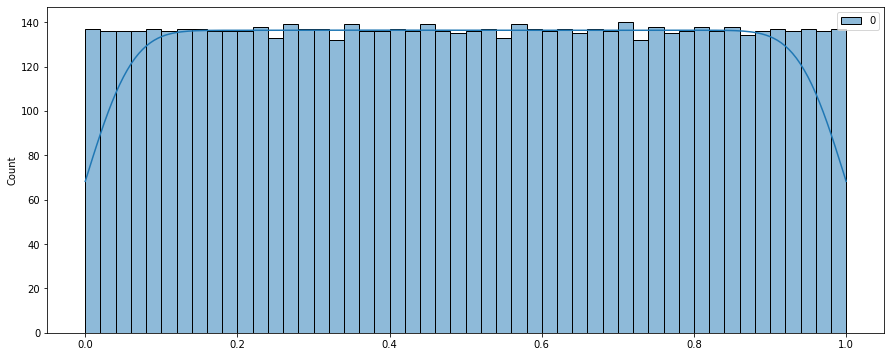

In [486]:
transformer = QuantileTransformer(random_state=11)
transformed_var = transformer.fit_transform(df[' Net Value Growth Rate'].values.reshape(-1, 1))
plt.figure(figsize=(15, 6))
sns.histplot(transformed_var, bins=50, kde=True)
plt.show()

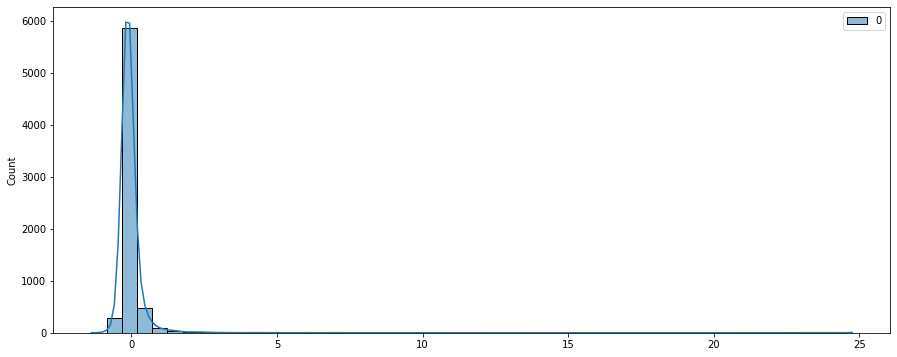

In [487]:
transformer = PowerTransformer()
transformed_var = transformer.fit_transform(df[' Net Value Growth Rate'].values.reshape(-1, 1))
plt.figure(figsize=(15, 6))
sns.histplot(transformed_var, bins=50, kde=True)
plt.show()

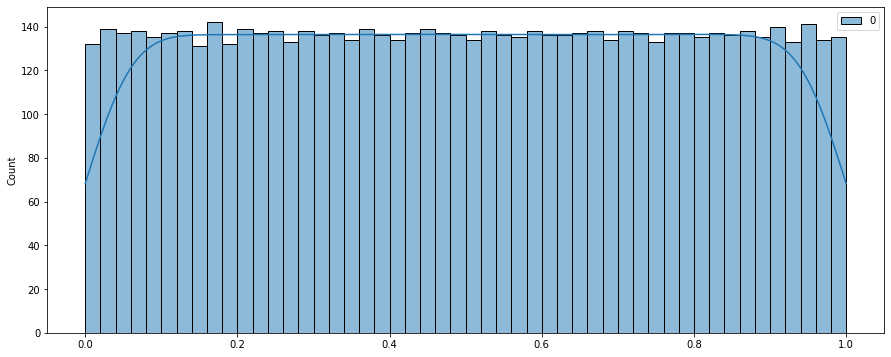

In [371]:
transformer = QuantileTransformer(random_state=11)
transformed_var = transformer.fit_transform(df[' Operating Expense Rate'].values.reshape(-1, 1))
plt.figure(figsize=(15, 6))
sns.histplot(transformed_var, bins=50, kde=True)
plt.show()

<AxesSubplot:>

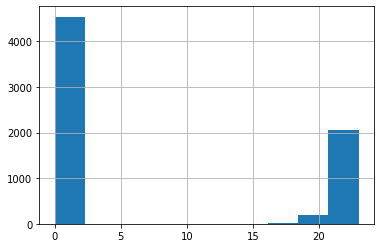

In [360]:
np.log1p(df[' Operating Expense Rate']).hist()

In [488]:
df_copy.drop(' Liability-Assets Flag', axis=1, inplace=True)

KeyError: "[' Liability-Assets Flag'] not found in axis"

In [471]:
var_range_zero_to_one.describe()

,Total income/Total expense,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Tax rate (A),Cash/Total Assets,Equity to Liability,Liability-Assets Flag
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.002549,0.008783,0.005968,0.115001,0.124095,0.047578,0.001173
std,0.012093,0.028153,0.012188,0.138667,0.139251,0.050014,0.034234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002236,0.005244,0.005366,0.000000,0.033543,0.024477,0.000000
50%,0.002336,0.005665,0.005366,0.073489,0.074887,0.033798,0.000000
75%,0.002492,0.006847,0.005764,0.205841,0.161073,0.052838,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [470]:
var_range_zero_to_one = df[[' Total income/Total expense', ' Long-term fund suitability ratio (A)', 
    ' Contingent liabilities/Net worth', ' Tax rate (A)', ' Cash/Total Assets', ' Equity to Liability', ' Liability-Assets Flag']]
high_var_range_zero_to_billion = df[[' Current Ratio', ' Fixed Assets to Assets', ' Net Value Growth Rate', 
                                   ' Revenue per person', ' Quick Assets/Current Liability', ' Revenue Per Share (Yuan �',
                                   ' Total debt/Total net worth', ' Quick Ratio', ' Allocation rate per person', 
                                   ' Average Collection Days', ' Accounts Receivable Turnover', 
                                   ' Total assets to GNP price', ' Cash/Current Liability', 
                                   ' Long-term Liability to Current Assets', ' Inventory/Current Liability', 
                                   ' Interest-bearing debt interest rate', ' Fixed Assets Turnover Frequency', 
                                   ' Current Asset Turnover Rate']]
med_var_range_zero_to_billion = df[[' Operating Expense Rate', ' Quick Asset Turnover Rate', 
                                  ' Inventory Turnover Rate (times)', ' Research and development expense rate',
                                   ' Cash Turnover Rate']]

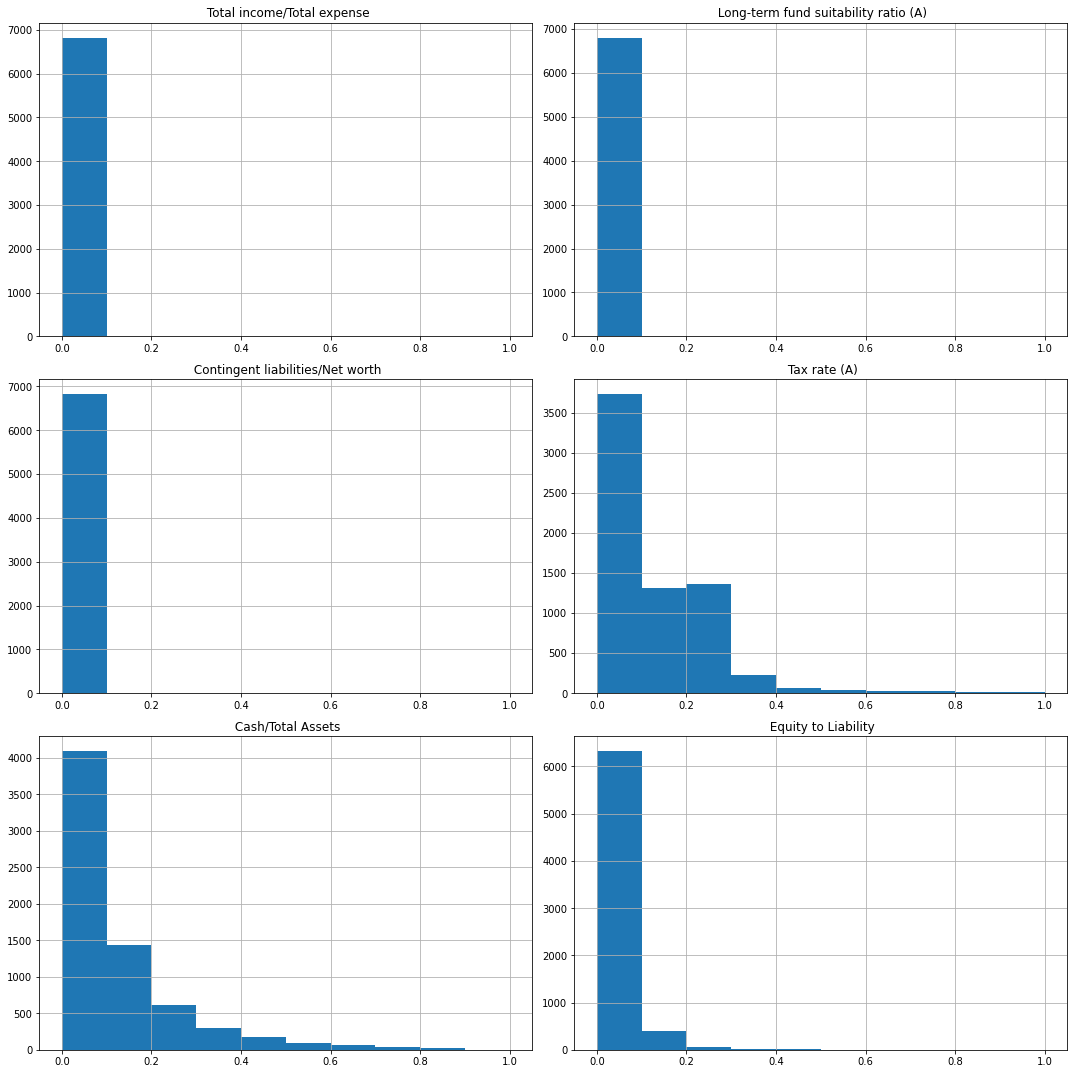

In [36]:
var_range_zero_to_one.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

In [33]:
var_range_zero_to_one.describe()

,Total income/Total expense,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Tax rate (A),Cash/Total Assets,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.002549,0.008783,0.005968,0.115001,0.124095,0.047578
std,0.012093,0.028153,0.012188,0.138667,0.139251,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002236,0.005244,0.005366,0.000000,0.033543,0.024477
50%,0.002336,0.005665,0.005366,0.073489,0.074887,0.033798
75%,0.002492,0.006847,0.005764,0.205841,0.161073,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
def remove_multicollinearity(data, target, vif_threshold=10):
    def calculate_vif(X, col):
        if col != target:
            vif = pd.DataFrame()
            vif["features"] = X.columns
            vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            vif = vif.sort_values(ascending=False, by='VIF')
            return vif

    features = data.select_dtypes(include=np.number)
    dropped_columns = []
    for col in features.columns:
        vif = calculate_vif(features, col)
        if vif is not None and vif["VIF"].max() > vif_threshold:
            remove_feature = vif.loc[vif["VIF"].idxmax()]["features"]
            data.drop(columns=[remove_feature], axis=1, inplace=True)
            dropped_columns.append(remove_feature)
            features = data.select_dtypes(include=np.number)
    return data, dropped_columns

In [128]:
target = "Bankrupt"
df_copy, dropped_cols = remove_multicollinearity(df, target)

In [129]:
df.shape

(6819, 47)

In [130]:
df_copy.shape

(6819, 47)

In [70]:
df_copy.drop([' Operating Funds to Liability', ' Per Share Net profit before tax (Yuan �'], axis=1, inplace=True)

In [131]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df))

Top Absolute Correlations
 Contingent liabilities/Net worth              Working Capital/Equity                 0.767778
 Total Asset Turnover                          Net Worth Turnover Rate (times)        0.757414
 Working Capital to Total Assets               Current Liability to Current Assets    0.625560
                                               Cash/Total Assets                      0.585770
 Inventory and accounts receivable/Net value   Equity to Long-term Liability          0.486097
dtype: float64


In [135]:
scaled_df.corr()['Bankrupt']

KeyError: 'Bankrupt'

In [134]:
for col in df_copy.columns:
    print(df_copy[col].skew())

-0.3239410025682502
-52.995743815248744
1.2486733165601693
1.2820432317125836
7.033376780370779
1.9038752526097866
8.018983542832348
43.7690982625658
77.92510906177942
-0.9187910949038905
80.29184419453097
82.57723657279894
31.644913015411564
-16.822554123443787
46.355335845692984
24.967872721716827
79.67062018465113
13.11223424050321
2.3409066221528594
25.84654655099649
30.58008623206861
1.1372886202283368
2.349802853236018
8.961848306944995
59.434479930512104
27.47614476109999
-0.1923113474832543
2.2303602460301155
47.94729978116933
14.863767667730757
11.965588148251964
-36.20365405315724
12.401607114804376
82.33242378018083
9.481727553381
2.1159556384021165
1.1373534593747237
0.9541170558810121
-47.8691121294848
82.57723657279898
33.78993976694663
13.18866054192225
29.15047171886589
21.75898297422601
45.72419711234114
7.4011008343230875
5.2953875158726404


In [149]:
cols = [col for col in df_copy.columns if df_copy[col].dtypes in ['int64', 'float64'] and col not in ['Bankrupt']]
cols

[' ROA(C) before interest and depreciation before interest',
 ' After-tax net Interest Rate',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Cash Flow Per Share',
 ' Revenue Per Share (Yuan �',
 ' Realized Sales Gross Profit Growth Rate',
 ' Total Asset Growth Rate',
 ' Net Value Growth Rate',
 ' Current Ratio',
 ' Quick Ratio',
 ' Interest Expense Ratio',
 ' Total debt/Total net worth',
 ' Long-term fund suitability ratio (A)',
 ' Contingent liabilities/Net worth',
 ' Inventory and accounts receivable/Net value',
 ' Total Asset Turnover',
 ' Accounts Receivable Turnover',
 ' Average Collection Days',
 ' Inventory Turnover Rate (times)',
 ' Fixed Assets Turnover Frequency',
 ' Net Worth Turnover Rate (times)',
 ' Revenue per person',
 ' Allocation rate per person',
 ' Working Capital to Total Assets',
 ' Cash/Total Assets',
 ' Quick Assets/Current Liability',
 ' Cash/Current Liability',
 ' Inventory/C

In [151]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

def scale_column(df, col_name, target):
    for col in col_name:
        if col != target:
            skewness = df[col].skew()
            if skewness > 1:
                df.loc[:, col] = np.log1p(df[col])
            elif skewness < -1:
                scaler = PowerTransformer(standardize=False)
                df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        else:
            continue
            
    return df

In [152]:
scaled_df = scale_column(df_copy, cols, 'Bankrupt')
scaled_df

,ROA(C) before interest and depreciation before interest,After-tax net Interest Rate,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Cash Flow Per Share,Revenue Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Working Capital to Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Working Capital/Equity,Long-term Liability to Current Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Equity to Long-term Liability,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,Degree of Financial Leverage (DFL),Equity to Liability,Bankrupt
0,0.370594,3.881676,0.000126,0.000000,0.000724,0.000000,0.240038,0.017110,0.021626,4.980000e+09,0.000327,0.002251,0.001206,0.700041,0.020611,0.004999,0.006437,0.288982,0.080087,0.001809,0.003469,0.000182,0.000116,0.031861,0.032507,0.035187,0.672775,0.004078,0.001991,0.000147,0.001034,1.495448,0.024650,0.002018,0.060944,3.061895,22.602731,4.580000e+08,1.039959,0.264499,0.112578,0.105949,0.0,0.009094,0.025914,0.016203,1
1,0.464291,3.884471,0.000290,0.000000,0.000646,0.000000,0.243902,0.020497,0.021605,6.110000e+09,0.000443,0.005962,0.004015,0.705979,0.012273,0.005033,0.005801,0.288816,0.060601,0.001284,0.004881,22.959711,3.063081,0.024853,0.006818,0.012111,0.751111,0.014728,0.004111,0.001381,0.005169,1.523509,0.023120,0.002221,0.024884,0.000107,22.764486,2.490000e+09,1.039964,0.281649,0.108088,0.045613,0.0,0.008221,0.210858,0.020372,1
2,0.426071,3.879277,0.000236,17.054189,0.000789,0.000000,0.237293,0.005892,0.022255,7.280000e+09,0.000396,0.011346,0.005305,0.699677,0.020594,0.005074,0.006519,0.293536,0.014772,0.001492,0.004200,17.989898,3.122269,0.013211,0.027794,0.116818,0.829502,0.000990,0.006244,1.423752,0.013596,1.551707,0.003695,0.002056,0.020941,0.001788,0.001022,7.610000e+08,1.039966,0.197397,0.105685,0.024722,0.0,0.037752,0.025871,0.016208,1
3,0.399844,3.882565,0.000108,0.000000,0.000449,0.000000,0.245999,0.014066,0.021572,4.880000e+09,0.000382,0.004168,0.002884,0.700356,0.009437,0.005022,0.005337,0.288923,0.082627,0.001960,0.003200,22.687577,3.175426,0.027302,0.015114,0.020662,0.725754,0.018503,0.002948,0.001009,0.003521,1.517870,0.021454,0.001828,0.023593,3.170528,22.523324,2.030000e+09,1.039870,0.312993,0.107964,0.063055,0.0,0.003237,0.026005,0.023423,1
4,0.465022,3.884488,22.788862,0.000000,0.000685,0.000000,0.244511,0.028430,0.021620,5.510000e+09,0.000439,0.005969,0.003707,0.706982,0.005110,0.005275,0.006580,0.290076,0.149815,0.001446,0.004338,0.000163,0.000293,0.038620,0.053491,0.023158,0.751822,0.013964,0.004248,0.000680,0.004833,1.523573,0.000000,0.002219,0.025710,3.162195,22.342654,8.240000e+08,1.039951,0.214119,0.100027,0.045567,0.0,0.003855,0.024156,0.034281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,3.884643,0.000151,22.227343,0.000179,0.102009,0.245581,0.020141,0.021886,7.070000e+09,0.000450,0.010289,0.005413,0.701706,0.006589,0.005124,0.005337,0.292593,0.093891,0.000689,0.009053,17.511862,0.000143,0.027149,0.006288,0.006253,0.817769,0.090606,0.005425,0.005033,0.012956,1.535941,0.001787,0.002261,0.018704,0.000229,0.000124,1.077940e-04,1.039963,0.254808,0.101400,0.027194,0.0,0.000465,0.026354,0.029027,0
6

In [87]:
df_copy.drop([' Operating Funds to Liability', ' Total Asset Turnover', ' Non-industry income and expenditure/revenue'], axis=1, inplace=True)

KeyError: "[' Operating Funds to Liability'] not found in axis"

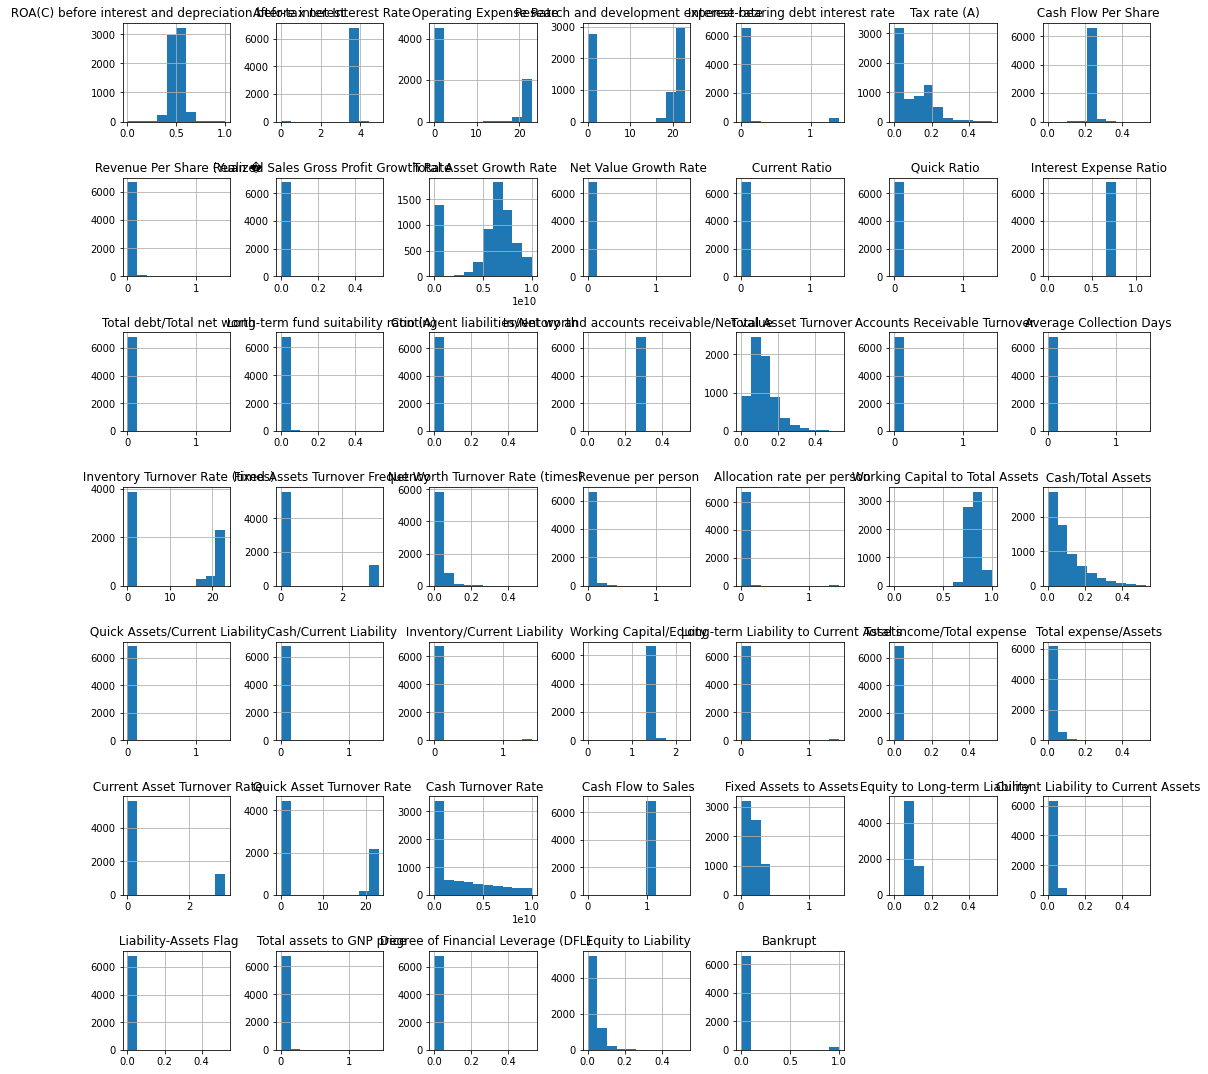

In [153]:
df.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

<AxesSubplot:>

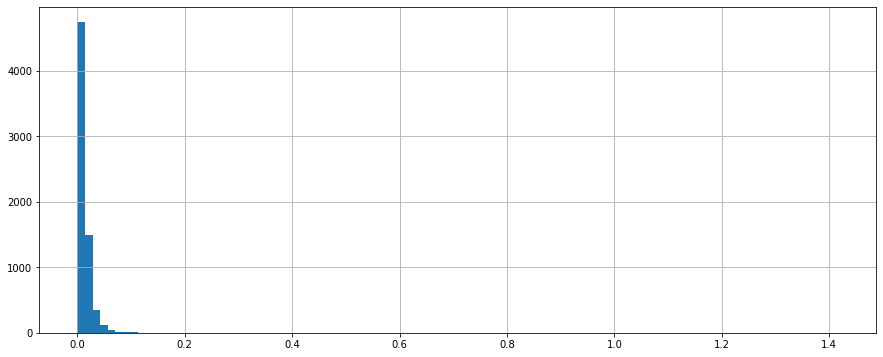

In [156]:
df_copy[' Current Ratio'].hist(figsize=(15, 6), bins=100)

<AxesSubplot:>

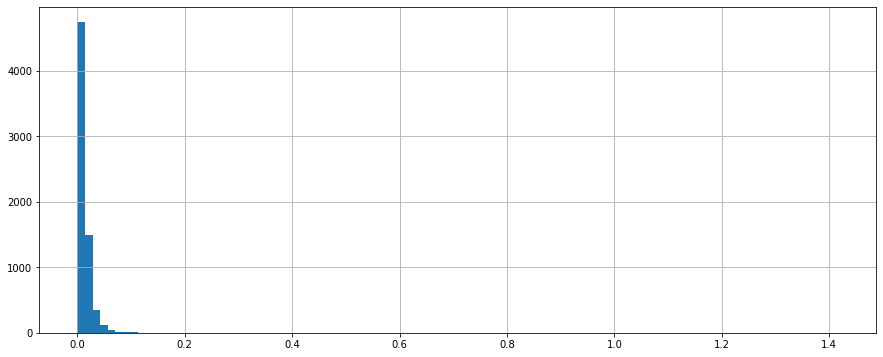

In [157]:
scaled_df[' Current Ratio'].hist(figsize=(15, 6), bins=100)

In [158]:
np.histogram_bin_edges(scaled_df[' Current Ratio'])

array([0.        , 0.14167993, 0.28335985, 0.42503978, 0.5667197 ,
       0.70839963, 0.85007955, 0.99175948, 1.1334394 , 1.27511933,
       1.41679925])

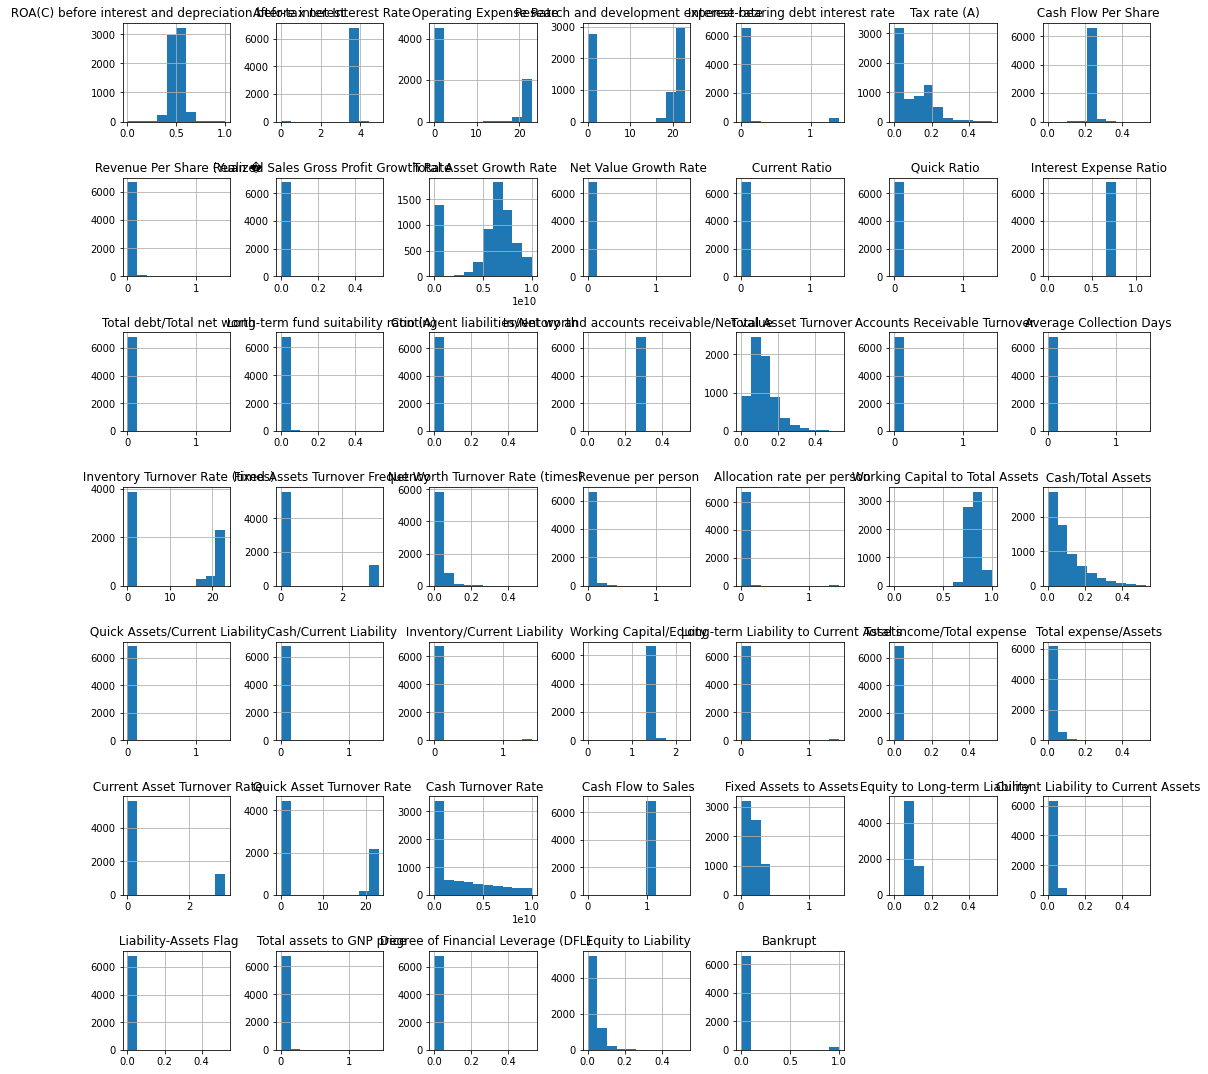

In [154]:
df_copy.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

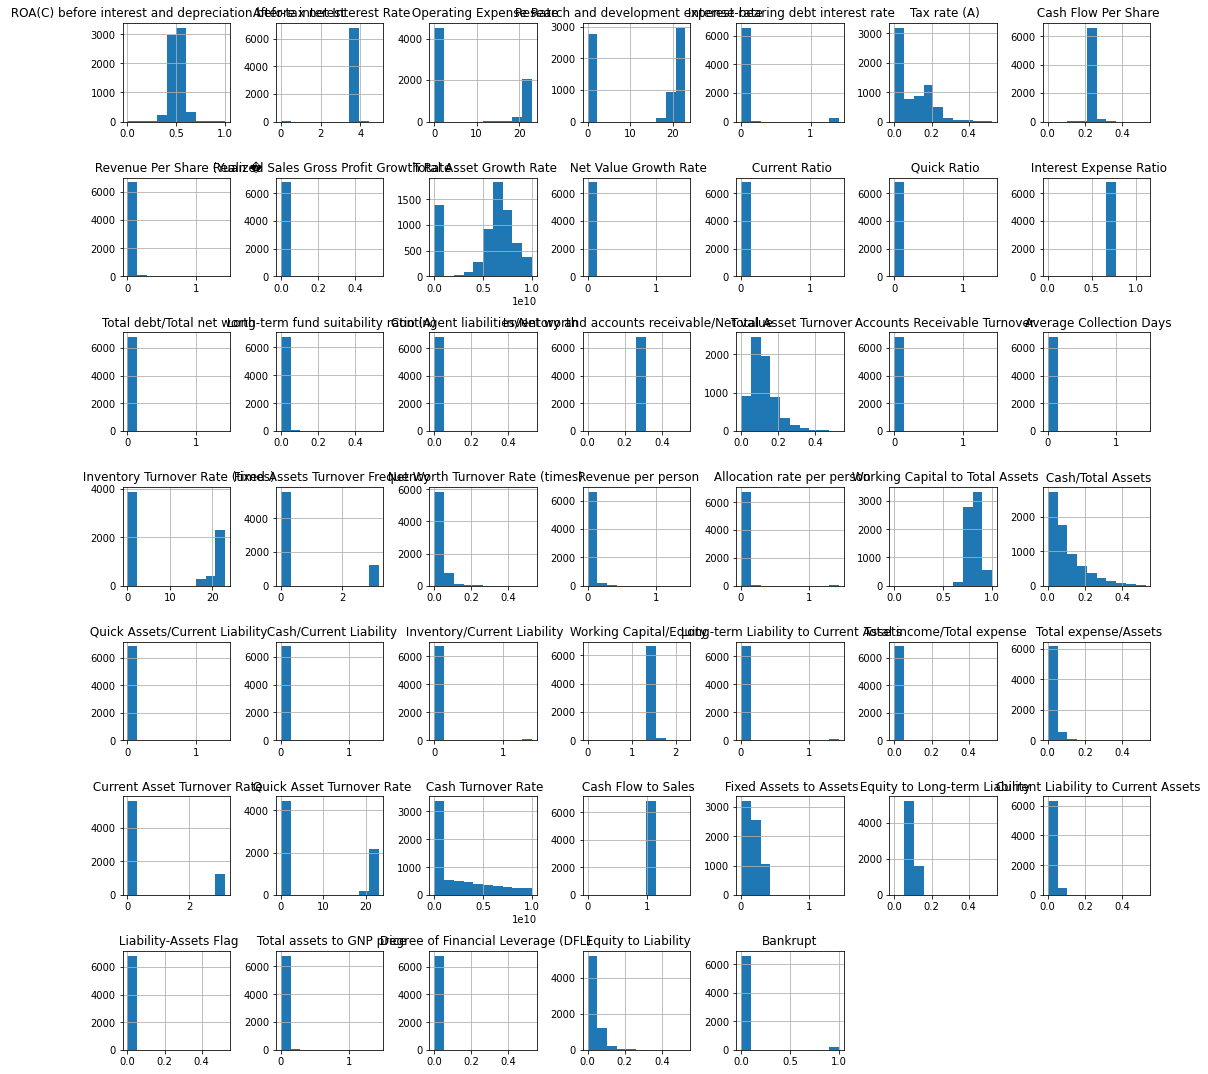

In [155]:
scaled_df.hist(figsize=(15, 15))
plt.tight_layout(pad=1)
plt.show()

In [ ]:
scaled_df[' ']

In [614]:
import statsmodels.api as sm

In [627]:
model = sm.Logit(y, X).fit()
print(model.summary())

         Current function value: inf
         Iterations: 35


C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [628]:
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Bankrupt   No. Observations:                 6819
Model:                            GLM   Df Residuals:                     6757
Model Family:                Binomial   Df Model:                           61
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -418.29
Date:                Sat, 22 Apr 2023   Deviance:                       656.17
Time:                        15:27:31   Pearson chi2:                 2.28e+03
No. Iterations:                    11   Pseudo R-squ. (CS):            0.07521
Covariance Type:            nonrobust                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [208]:
np.histogram_bin_edges(scaled_df[' Degree of Financial Leverage (DFL)'])

array([0.        , 0.0526589 , 0.10531781, 0.15797671, 0.21063561,
       0.26329452, 0.31595342, 0.36861232, 0.42127123, 0.47393013,
       0.52658903])

In [218]:
scaled_df.groupby('Bankrupt')[' Allocation rate per person'].value_counts()

Bankrupt   Allocation rate per person
0         0.000000                       5
          0.000171                       2
          0.000242                       2
          0.000521                       2
          0.000916                       2
                                        ..
1         0.207856                       1
          0.209002                       1
          0.234853                       1
          0.332359                       1
          1.419294                       1
Name:  Allocation rate per person, Length: 6771, dtype: int64

In [214]:
from optbinning import OptimalBinning
optb = OptimalBinning(name=str(scaled_df[' Degree of Financial Leverage (DFL)']), dtype="numerical", 
                      strategy='cart', solver="cp")
optb.fit(X, y)

ValueError: operands could not be broadcast together with shapes (6819,46) (6819,) 

<AxesSubplot:>

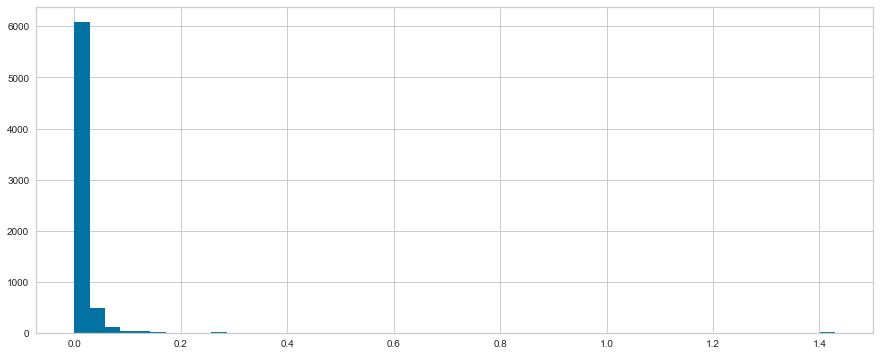

In [217]:
scaled_df[' Allocation rate per person'].hist(figsize=(15, 6), bins=50)

In [253]:
X = scaled_df.drop('Bankrupt', axis=1)
X_mean = X.mean(axis=0)
var = np.var(X/X_mean)
var_ = var.sort_values(ascending=False)
var_

 Liability-Assets Flag                                      851.375000
 Net Value Growth Rate                                      601.973370
 Accounts Receivable Turnover                               152.933556
 Total assets to GNP price                                   47.081079
 Net Worth Turnover Rate (times)                             45.859486
 Average Collection Days                                     43.462239
 Long-term Liability to Current Assets                       36.535636
 Inventory/Current Liability                                 33.929348
 Cash/Current Liability                                      29.938359
 Interest-bearing debt interest rate                         29.032101
 Total debt/Total net worth                                  28.862666
 Cash Flow to Sales                                          23.565241
 Fixed Assets to Assets                                      22.918098
 Research and development expense rate                       20.000976
 Quick

In [244]:
independent_cols = [' Cash/Total Assets', ' Equity to Liability',
       ' Research and development expense rate', ' Total expense/Assets',
       ' Net Worth Turnover Rate (times)',
       ' Current Liability to Current Assets', ' Fixed Assets to Assets',
       ' Total Asset Turnover', ' Total Asset Growth Rate',
       ' Degree of Financial Leverage (DFL)',
       ' Realized Sales Gross Profit Growth Rate',
       ' ROA(C) before interest and depreciation before interest',
       ' Equity to Long-term Liability', ' Working Capital to Total Assets',
       ' Cash Flow Per Share', ' Inventory and accounts receivable/Net value',
       ' Interest Expense Ratio', ' Working Capital/Equity',
       ' After-tax net Interest Rate', ' Cash Flow to Sales']
target = y

In [251]:
from optbinning import OptimalBinning
for col in independent_cols:
    ob = OptimalBinning(name=col, dtype="numerical", solver="cp")
    ob.fit(scaled_df[col], target)
    scaled_df[col] = ob.transform(scaled_df[col])

In [252]:
scaled_df

,ROA(C) before interest and depreciation before interest,After-tax net Interest Rate,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Cash Flow Per Share,Revenue Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Working Capital to Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Working Capital/Equity,Long-term Liability to Current Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Equity to Long-term Liability,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,Degree of Financial Leverage (DFL),Equity to Liability,Bankrupt
0,-2.132535,-2.029350,0.000126,-0.566344,0.000724,0.000000,-0.937437,0.017110,0.934376,-0.589236,0.000327,0.002251,0.001206,-1.683394,0.020611,0.004999,0.006437,1.514057,-0.185654,0.001809,0.003469,0.000182,0.000116,0.338692,0.032507,0.035187,-2.221465,-1.611398,0.001991,0.000147,0.001034,-2.263518,0.024650,0.002018,-0.551917,3.061895,22.602731,4.580000e+08,-0.050709,-0.149822,-1.465392,-1.829428,0.0,0.009094,-1.630793,-1.914570,1
1,-0.760366,-0.515128,0.000290,-0.566344,0.000646,0.000000,-0.501940,0.020497,0.095462,-0.014962,0.000443,0.005962,0.004015,-0.853338,0.012273,0.005033,0.005801,0.736119,-0.476651,0.001284,0.004881,22.959711,3.063081,0.148757,0.006818,0.012111,-0.328897,-0.454370,0.004111,0.001381,0.005169,-0.294220,0.023120,0.002221,0.142652,0.000107,22.764486,2.490000e+09,-0.050709,-0.149822,-0.342833,-0.694958,0.0,0.008221,-0.756711,-0.850511,1
2,-1.293930,-2.029350,0.000236,0.068624,0.000789,0.000000,-0.937437,0.005892,-0.160860,0.505778,0.000396,0.011346,0.005305,-1.683394,0.020594,0.005074,0.006519,-0.307333,-1.191203,0.001492,0.004200,17.989898,3.122269,-0.399083,0.027794,0.116818,0.567147,-1.611398,0.006244,1.423752,0.013596,-0.074812,0.003695,0.002056,0.255368,0.001788,0.001022,7.610000e+08,-0.050709,-0.149822,-0.012205,1.212326,0.0,0.037752,-1.630793,-1.914570,1
3,-2.132535,-1.634604,0.000108,-0.566344,0.000449,0.000000,0.333643,0.014066,0.095462,-0.589236,0.000382,0.004168,0.002884,-1.283603,0.009437,0.005022,0.005337,1.514057,-0.045643,0.001960,0.003200,22.687577,3.175426,0.148757,0.015114,0.020662,-2.221465,-0.454370,0.002948,0.001009,0.003521,-2.263518,0.021454,0.001828,0.255368,3.170528,22.523324,2.030000e+09,-0.879772,-0.698567,-0.342833,-1.829428,0.0,0.003237,-1.291652,-0.004861,1
4,-0.760366,-0.515128,22.788862,-0.566344,0.000685,0.000000,-0.501940,0.028430,0.934376,-0.589236,0.000439,0.005969,0.003707,-0.853338,0.005110,0.005275,0.006580,0.439600,0.582988,0.001446,0.004338,0.000163,0.000293,-0.100590,0.053491,0.023158,-0.328897,-0.454370,0.004248,0.000680,0.004833,-0.294220,0.000000,0.002219,0.142652,3.162195,22.342654,8.240000e+08,-0.050709,-0.149822,0.705405,-0.694958,0.0,0.003855,-1.630793,1.300732,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.546848,0.870980,0.000151,0.068624,0.000179,0.102009,0.333643,0.020141,0.399347,0.505778,0.000450,0.010289,0.005413,3.268029,0.006589,0.005124,0.005337,0.155517,-0.045643,0.000689,0.009053,17.511862,0.000143,0.148757,0.006288,0.006253,0.567147,0.343403,0.005425,0.005033,0.012956,1.817145,0.001787,0.002261,0.255368,0.000229,0.000124,1.077940e-04,-0.050709,-0.14982

In [225]:
variable = ' Revenue Per Share (Yuan �'
x = scaled_df[variable].values
y = scaled_df['Bankrupt']

In [226]:
from optbinning import OptimalBinning
optb = OptimalBinning(name=variable,  dtype="numerical", solver="cp")
optb.fit(x, y)

OptimalBinning(name=' Revenue Per Share (Yuan �')

In [227]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.01)",368,0.053967,338,30,0.081522,-0.979197,0.083373,0.010024
1,"[0.01, 0.01)",790,0.115853,753,37,0.046835,-0.387899,0.020975,0.002606
2,"[0.01, 0.02)",781,0.114533,746,35,0.044814,-0.341668,0.015732,0.001957
3,"[0.02, 0.03)",1556,0.228186,1505,51,0.032776,-0.016323,0.000061,0.000008
4,"[0.03, 0.05)",1835,0.269101,1790,45,0.024523,0.282263,0.018829,0.002346
5,"[0.05, 0.07)",717,0.105147,705,12,0.016736,0.672245,0.035151,0.004313
6,"[0.07, 0.09)",421,0.061739,414,7,0.016627,0.67891,0.020991,0.002575
7,"[0.09, inf)",351,0.051474,348,3,0.008547,1.352544,0.052883,0.006149
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [674]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=0.75)
model = RandomForestClassifier(random_state=11)
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, scaled_df, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise', verbose=True)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Accuracy: 0.256 (0.079)


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished


In [182]:
X.shape

(6819, 46)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

n_features = range(10, 46, 1)
for i in n_features:
    select = RFE(xgb.XGBClassifier(), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)
    model = xgb.XGBClassifier().fit(X_train_rfe, y_train)
    preds = model.predict(X_test_rfe)
    score = f1_score(preds, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.352  number of features: 10
Test score: 0.341  number of features: 11
Test score: 0.306  number of features: 12
Test score: 0.302  number of features: 13
Test score: 0.364  number of features: 14
Test score: 0.366  number of features: 15
Test score: 0.366  number of features: 16
Test score: 0.308  number of features: 17
Test score: 0.330  number of features: 18
Test score: 0.276  number of features: 19
Test score: 0.378  number of features: 20
Test score: 0.353  number of features: 21
Test score: 0.302  number of features: 22
Test score: 0.333  number of features: 23
Test score: 0.310  number of features: 24
Test score: 0.262  number of features: 25
Test score: 0.322  number of features: 26
Test score: 0.364  number of features: 27
Test score: 0.322  number of features: 28
Test score: 0.322  number of features: 29
Test score: 0.313  number of features: 30
Test score: 0.282  number of features: 31
Test score: 0.341  number of features: 32
Test score: 0.289  number of featu

In [179]:
model = RandomForestClassifier(random_state=1, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [180]:
important_features = model.feature_importances_
feature_importance = pd.Series(important_features, index=X.columns)
feature_importance = feature_importance.reset_index(name='Values')
feature_importance

,index,Values
0,ROA(C) before interest and depreciation befor...,0.070317
1,After-tax net Interest Rate,0.091892
2,Operating Expense Rate,0.014691
3,Research and development expense rate,0.021313
4,Interest-bearing debt interest rate,0.014056
5,Tax rate (A),0.005196
6,Cash Flow Per Share,0.014195
7,Revenue Per Share (Yuan �,0.007501
8,Realized Sales Gross Profit Growth Rate,0.006583
9,Total Asset Growth Rate,0.014024


C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


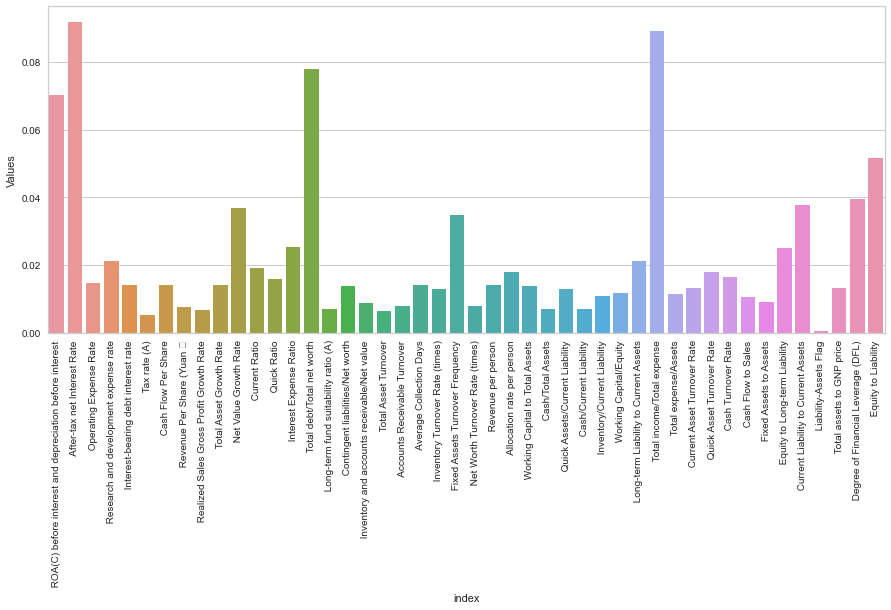

In [181]:
plt.figure(figsize=(15, 6))
sns.barplot(data=feature_importance, x='index', y='Values')
plt.xticks(rotation=90)
plt.show()

In [192]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = scaled_df.drop('Bankrupt', axis=1)
y = scaled_df['Bankrupt']
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features=discrete_features)
mi_scores

 Interest Expense Ratio                                     0.036228
 Net Value Growth Rate                                      0.035545
 Degree of Financial Leverage (DFL)                         0.034929
 Total debt/Total net worth                                 0.034631
 Equity to Liability                                        0.034437
 Total income/Total expense                                 0.030824
 ROA(C) before interest and depreciation before interest    0.030202
 After-tax net Interest Rate                                0.029161
 Quick Ratio                                                0.024690
 Working Capital to Total Assets                            0.023339
 Current Ratio                                              0.022970
 Current Liability to Current Assets                        0.022923
 Cash/Current Liability                                     0.021973
 Tax rate (A)                                               0.020240
 Quick Assets/Current Liability   

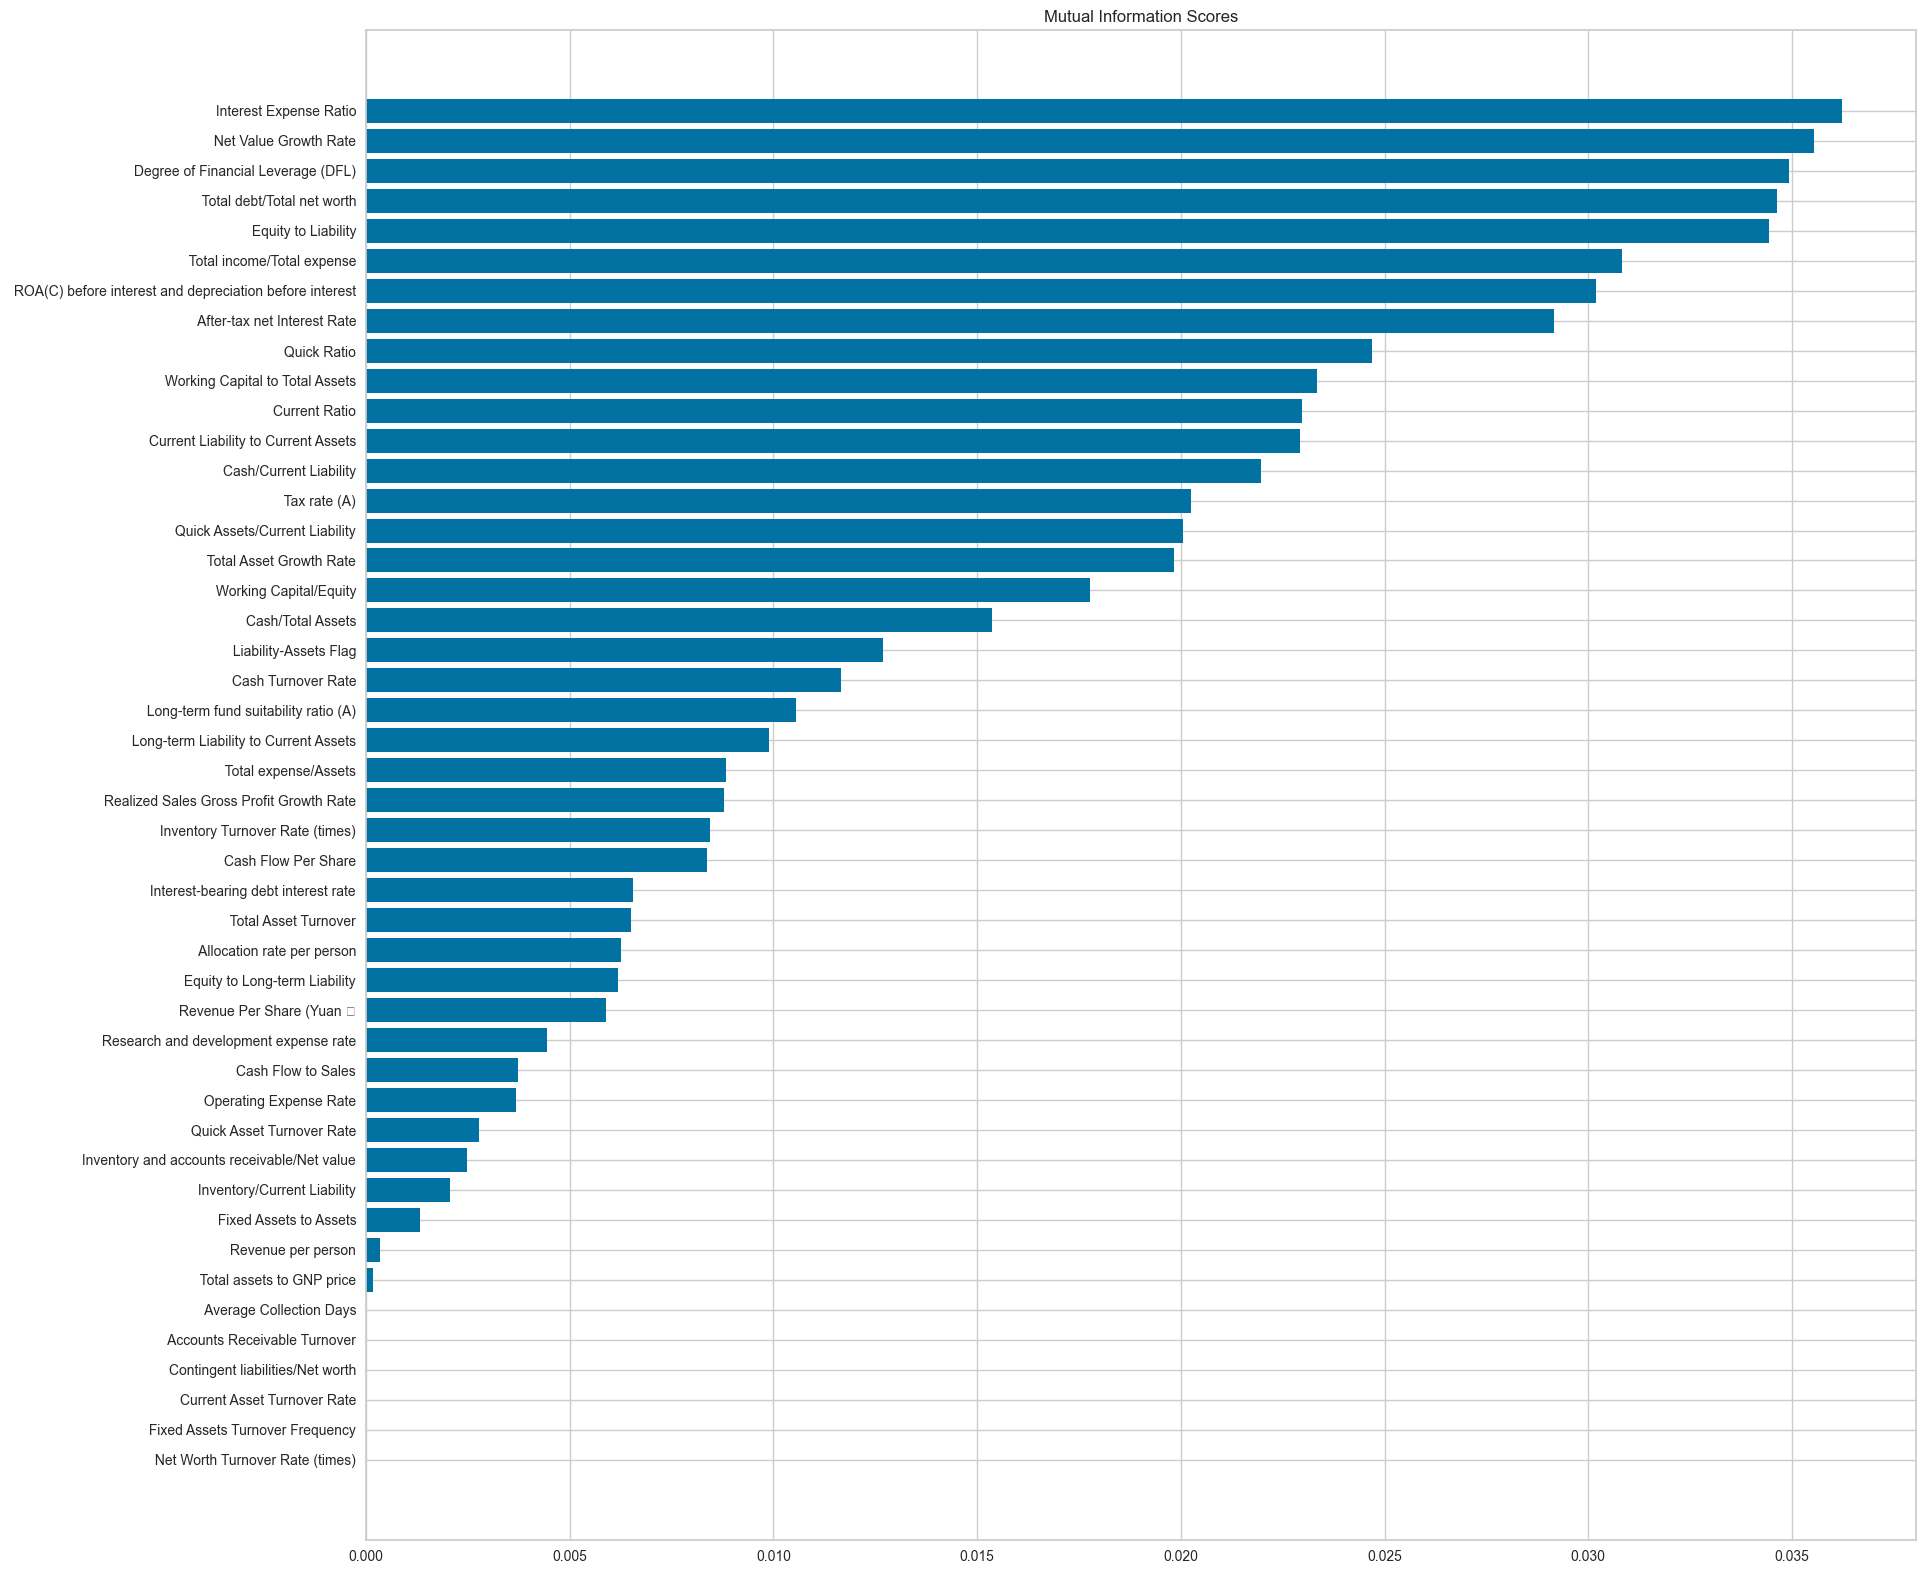

In [194]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(20, 20))
plot_mi_scores(mi_scores)

In [197]:
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectFwe, chi2

label = df['Bankrupt']
ratio = float(np.sum(label == 0)) / np.sum(label == 1)

X_new = SelectFpr(chi2, alpha=0.1).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

model = xgb.XGBClassifier(eta=0.85, max_depth=6, max_leaves=700, subsample=0.3, max_delta_step=46, 
                          colsample_bytree=0.5, colsample_bynode=0.5, colsample_bylevel=0.8, scale_pos_weight=ratio)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[1434  213]
 [  14   44]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1647
           1       0.17      0.76      0.28        58

    accuracy                           0.87      1705
   macro avg       0.58      0.81      0.60      1705
weighted avg       0.96      0.87      0.90      1705



In [198]:
X_new = SelectFdr(chi2, alpha=0.1).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

model = xgb.XGBClassifier(eta=0.85, max_depth=6, max_leaves=700, subsample=0.3, max_delta_step=46, 
                          colsample_bytree=0.5, colsample_bynode=0.5, colsample_bylevel=0.8, scale_pos_weight=ratio)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[1465  182]
 [  17   41]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1647
           1       0.18      0.71      0.29        58

    accuracy                           0.88      1705
   macro avg       0.59      0.80      0.61      1705
weighted avg       0.96      0.88      0.91      1705



In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestClassifier(), threshold="1.25*mean").fit(X, y)
print(selector.estimator_.coef_)
print(selector.threshold_)
print(abs(selector.estimator_.coef_).mean()*1.25) 

In [760]:
n_features_to_select = 13
rfe = RFE(xgb.XGBClassifier(eta=0.263, max_depth=10, reg_alpha=30, gamma=50, reg_lambda=80, max_delta_step=30, 
                              max_leaves=20, min_child_weight=0), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eta=0.263,
                            eval_metric=None, gamma=50, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_to_onehot=None,
                            max_delta_step=30, max_depth=10, max_leaves=20,
                            min_child_weight=0, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=30, ...),
    n_features_to_select=13)

In [761]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1  ROA(C) before interest and depreciation before interest
1  Interest-bearing debt interest rate
1  Net Value Growth Rate
1  Quick Ratio
1  Total debt/Total net worth
1  Inventory and accounts receivable/Net value
1  Allocation rate per person
1  Cash/Total Assets
1  Retained Earnings to Total Assets
1  Cash Turnover Rate
1  Equity to Long-term Liability
1  Net Income to Stockholder's Equity
1  Degree of Financial Leverage (DFL)


In [711]:
predictions = rfe.predict(X_test)

In [712]:
print(confusion_matrix(predictions, y_test))

[[1624   50]
 [  13   18]]


In [713]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1675
           1       0.24      0.53      0.33        30

    accuracy                           0.96      1705
   macro avg       0.61      0.75      0.65      1705
weighted avg       0.98      0.96      0.97      1705



In [416]:
def optimize(params, X, y):
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=2)
    f1_scores = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, pred))
    return np.mean(f1_scores)

In [418]:
param_space = {
    'eta': scope.int(hp.quniform('eta', 0.001, 0.9, 0.001)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 21, 1)),
    'gamma': scope.int(hp.quniform('gamma', 1, 100, 10)),
    'lambda': scope.int(hp.quniform('lambda', 1, 100, 10)),
    'alpha': scope.int(hp.quniform('alpha', 0, 100, 10)),
    'max_leaves': scope.int(hp.quniform('max_leaves', 10, 100, 10)),
}

optimization_function = partial(optimize, X=X_resampled, y=y_resampled)
trials = Trials()
results = fmin(
    fn=optimization_function,
    space=param_space,
    max_evals=20,
    trials=trials,
    algo=tpe.suggest
)

100%|███████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.58s/trial, best loss: 0.0]


In [419]:
results

{'alpha': 10.0,
 'eta': 0.448,
 'gamma': 10.0,
 'lambda': 80.0,
 'max_depth': 8.0,
 'max_leaves': 50.0}

In [ ]:
[' ROA(C) before interest and depreciation before interest',
1  Interest-bearing debt interest rate
1  Net Value Growth Rate
1  Quick Ratio
1  Total debt/Total net worth
1  Inventory and accounts receivable/Net value
1  Allocation rate per person
1  Cash/Total Assets
1  Retained Earnings to Total Assets
1  Cash Turnover Rate
1  Equity to Long-term Liability
1  Net Income to Stockholder's Equity
1  Degree of Financial Leverage (DFL)

In [719]:
updated_scaled_df = scaled_df[[' ROA(C) before interest and depreciation before interest', ' Interest-bearing debt interest rate', 
          ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth', ' Inventory and accounts receivable/Net value',
          ' Allocation rate per person', ' Cash/Total Assets', ' Retained Earnings to Total Assets', ' Cash Turnover Rate',
          ' Equity to Long-term Liability', " Net Income to Stockholder's Equity", ' Degree of Financial Leverage (DFL)']]

In [318]:
scaled_df

,ROA(C) before interest and depreciation before interest,After-tax net Interest Rate,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Cash Flow Per Share,Revenue Per Share (Yuan �,Realized Sales Gross Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Long-term fund suitability ratio (A),Contingent liabilities/Net worth,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Allocation rate per person,Working Capital to Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Inventory/Current Liability,Working Capital/Equity,Long-term Liability to Current Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Equity to Long-term Liability,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,Degree of Financial Leverage (DFL),Equity to Liability,Bankrupt
0,-2.132535,-2.029350,0.000126,-0.566344,0.000724,0.000000,-0.937437,0.017110,0.934376,-0.589236,0.000327,0.002251,0.001206,-1.683394,0.020611,0.004999,0.006437,1.514057,-0.185654,0.001809,0.003469,0.000182,0.000116,0.338692,0.032507,0.035187,-2.221465,-1.611398,0.001991,0.000147,0.001034,-2.263518,0.024650,0.002018,-0.551917,3.061895,22.602731,4.580000e+08,-0.050709,-0.149822,-1.465392,-1.829428,0.0,0.009094,-1.630793,-1.914570,1
1,-0.760366,-0.515128,0.000290,-0.566344,0.000646,0.000000,-0.501940,0.020497,0.095462,-0.014962,0.000443,0.005962,0.004015,-0.853338,0.012273,0.005033,0.005801,0.736119,-0.476651,0.001284,0.004881,22.959711,3.063081,0.148757,0.006818,0.012111,-0.328897,-0.454370,0.004111,0.001381,0.005169,-0.294220,0.023120,0.002221,0.142652,0.000107,22.764486,2.490000e+09,-0.050709,-0.149822,-0.342833,-0.694958,0.0,0.008221,-0.756711,-0.850511,1
2,-1.293930,-2.029350,0.000236,0.068624,0.000789,0.000000,-0.937437,0.005892,-0.160860,0.505778,0.000396,0.011346,0.005305,-1.683394,0.020594,0.005074,0.006519,-0.307333,-1.191203,0.001492,0.004200,17.989898,3.122269,-0.399083,0.027794,0.116818,0.567147,-1.611398,0.006244,1.423752,0.013596,-0.074812,0.003695,0.002056,0.255368,0.001788,0.001022,7.610000e+08,-0.050709,-0.149822,-0.012205,1.212326,0.0,0.037752,-1.630793,-1.914570,1
3,-2.132535,-1.634604,0.000108,-0.566344,0.000449,0.000000,0.333643,0.014066,0.095462,-0.589236,0.000382,0.004168,0.002884,-1.283603,0.009437,0.005022,0.005337,1.514057,-0.045643,0.001960,0.003200,22.687577,3.175426,0.148757,0.015114,0.020662,-2.221465,-0.454370,0.002948,0.001009,0.003521,-2.263518,0.021454,0.001828,0.255368,3.170528,22.523324,2.030000e+09,-0.879772,-0.698567,-0.342833,-1.829428,0.0,0.003237,-1.291652,-0.004861,1
4,-0.760366,-0.515128,22.788862,-0.566344,0.000685,0.000000,-0.501940,0.028430,0.934376,-0.589236,0.000439,0.005969,0.003707,-0.853338,0.005110,0.005275,0.006580,0.439600,0.582988,0.001446,0.004338,0.000163,0.000293,-0.100590,0.053491,0.023158,-0.328897,-0.454370,0.004248,0.000680,0.004833,-0.294220,0.000000,0.002219,0.142652,3.162195,22.342654,8.240000e+08,-0.050709,-0.149822,0.705405,-0.694958,0.0,0.003855,-1.630793,1.300732,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.546848,0.870980,0.000151,0.068624,0.000179,0.102009,0.333643,0.020141,0.399347,0.505778,0.000450,0.010289,0.005413,3.268029,0.006589,0.005124,0.005337,0.155517,-0.045643,0.000689,0.009053,17.511862,0.000143,0.148757,0.006288,0.006253,0.567147,0.343403,0.005425,0.005033,0.012956,1.817145,0.001787,0.002261,0.255368,0.000229,0.000124,1.077940e-04,-0.050709,-0.14982

In [424]:
X = scaled_df.drop('Bankrupt', axis=1)
y = scaled_df['Bankrupt']

In [425]:
X_resampled, y_resampled = ADASYN(sampling_strategy='minority').fit_resample(X, y)

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [426]:
splits = 2
skf = StratifiedKFold(n_splits=splits)
for fold, (train_idx, test_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

In [427]:
{'alpha': 10.0,
 'eta': 0.448,
 'gamma': 10.0,
 'lambda': 80.0,
 'max_depth': 8.0,
 'max_leaves': 50.0}

model_lr = LogisticRegression(max_iter=1500, random_state=1, class_weight='balanced', C=4.482249796656961e-06,
                           tol=29, penalty='l2', solver='lbfgs')
model_rf = RandomForestClassifier(random_state=1, class_weight='balanced')
dtree = DecisionTreeClassifier()
model_xgb = xgb.XGBClassifier(eta=0.448, max_depth=8, alpha=10, max_leaves=50,
                              gamma=10, reg_lambda=80)
model_svm = SVC()
scaler = RobustScaler()
quantile_transformer = QuantileTransformer(random_state=0)
power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
pca = PCA(n_components=0.95, random_state=1, whiten=True)

In [428]:
pipe = Pipeline([('model', model_xgb)])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

In [429]:
print(confusion_matrix(preds, y_test))

[[3194  115]
 [ 106 3160]]


In [430]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3309
           1       0.96      0.97      0.97      3266

    accuracy                           0.97      6575
   macro avg       0.97      0.97      0.97      6575
weighted avg       0.97      0.97      0.97      6575



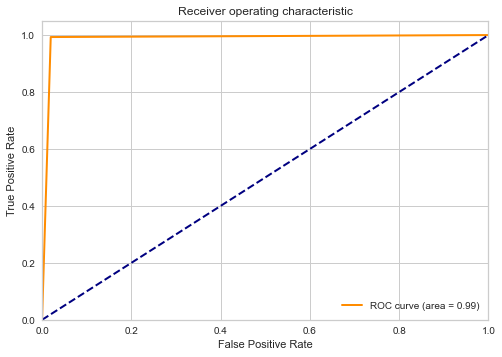

In [341]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test contains the true binary labels, and y_pred contains the predicted probabilities
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [342]:
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold

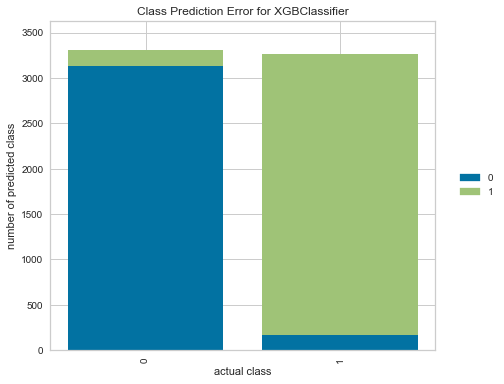

<AxesSubplot:title={'center':'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [431]:
model_xgb = xgb.XGBClassifier(eta=0.263, max_depth=10, reg_alpha=30, gamma=50, reg_lambda=80, max_delta_step=30, 
                              max_leaves=20, min_child_weight=0)
visualizer = ClassPredictionError(model_xgb)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.savefig('classprediction.png')
visualizer.show() 

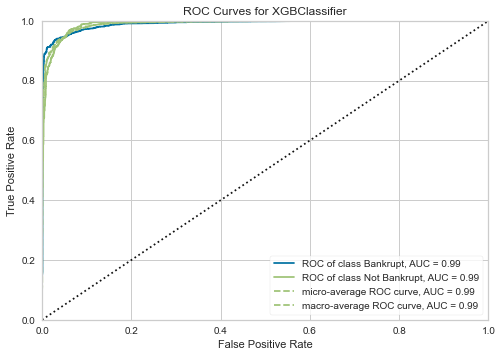

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [432]:
visualizer = ROCAUC(model_xgb, classes=["Bankrupt", "Not Bankrupt"])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

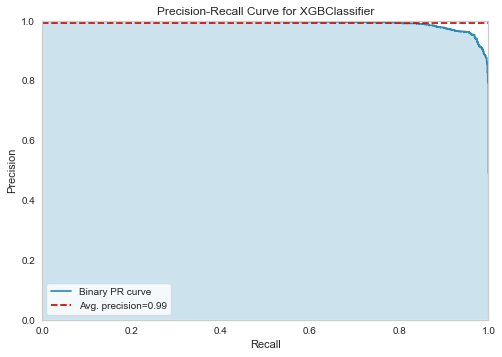

<AxesSubplot:title={'center':'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [345]:
viz = PrecisionRecallCurve(model_xgb)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [316]:
from yellowbrick.features import RadViz

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.


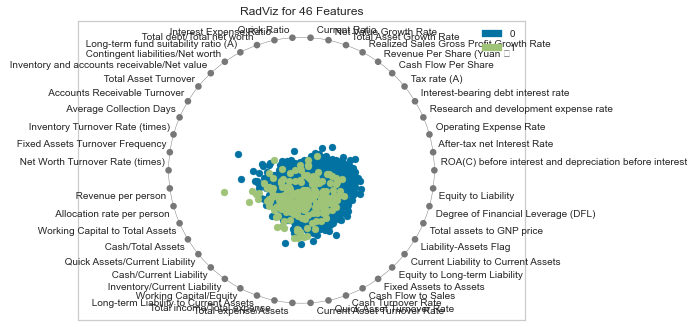

<AxesSubplot:title={'center':'RadViz for 46 Features'}>

In [346]:
visualizer = RadViz(classes=[0, 1])
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show() 

In [347]:
import shap

In [433]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


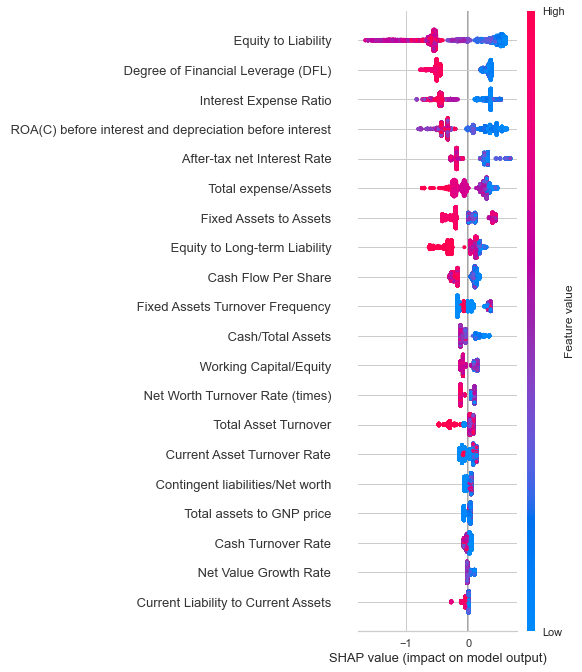

<Figure size 576x396 with 0 Axes>

In [434]:
shap.summary_plot(shap_values, X_test)
plt.savefig('shap.png')
plt.show()

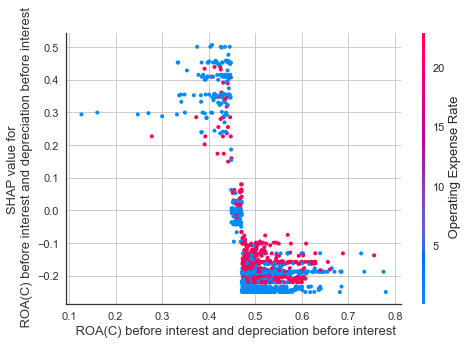

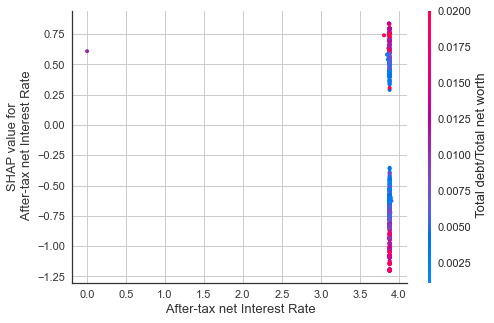

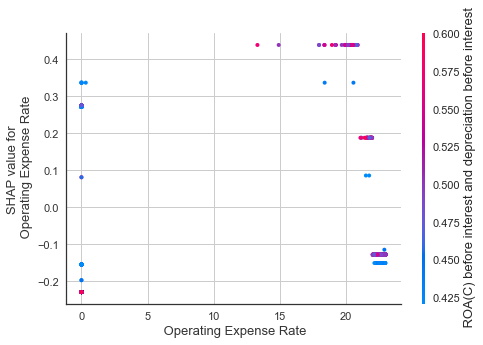

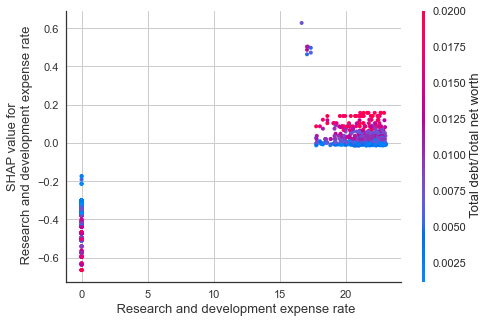

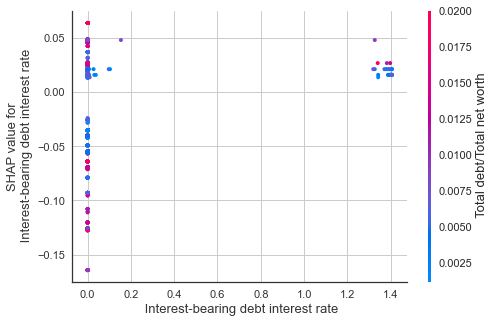

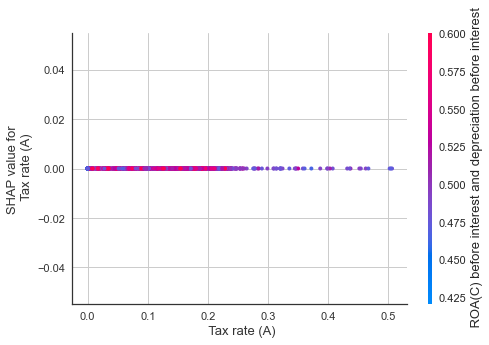

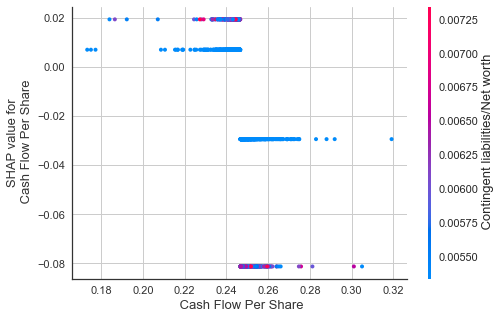

Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.


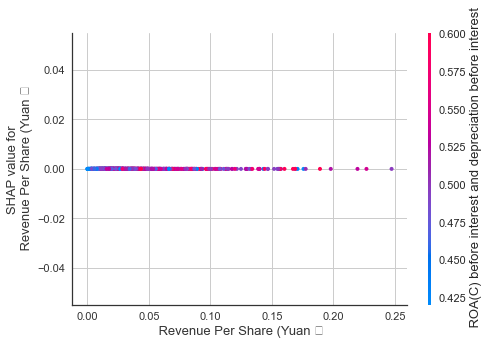

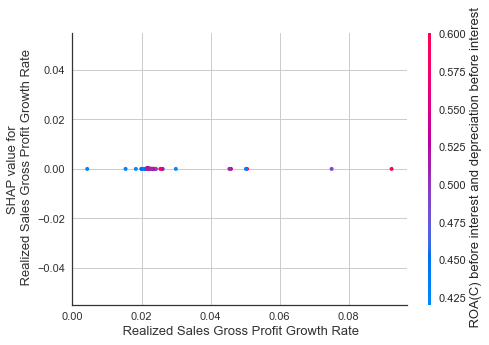

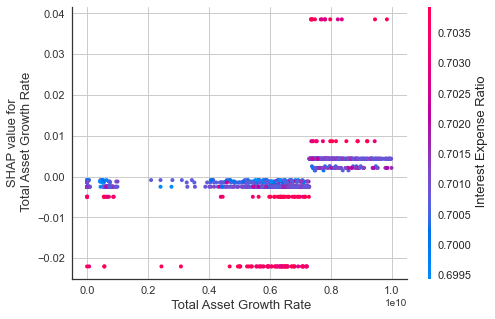

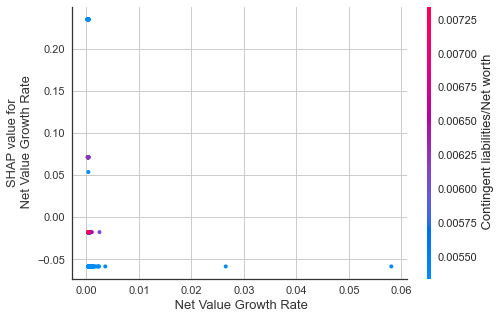

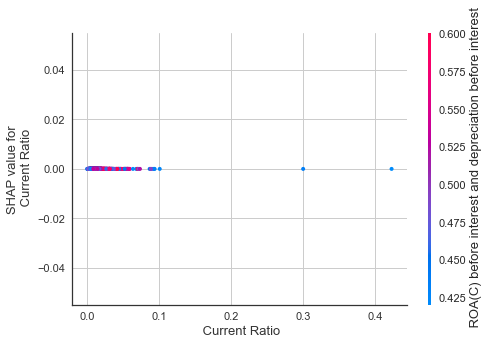

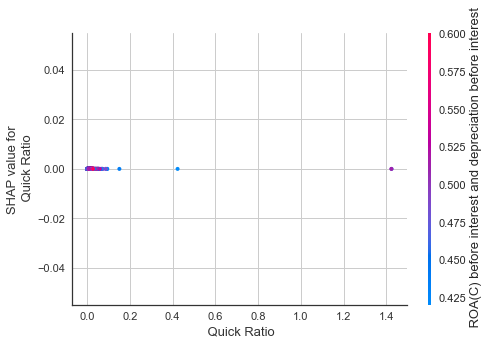

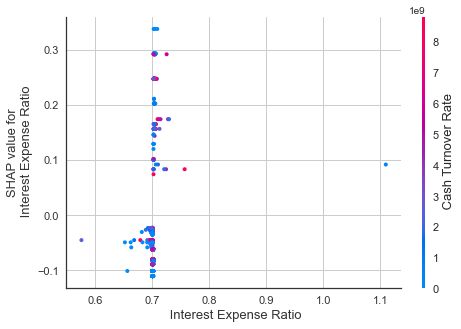

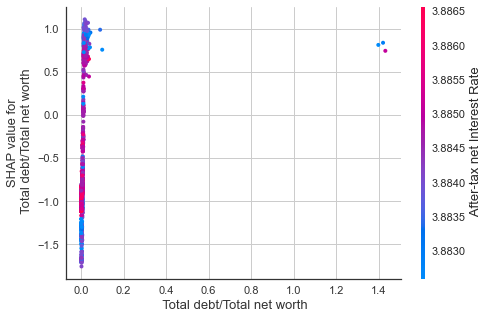

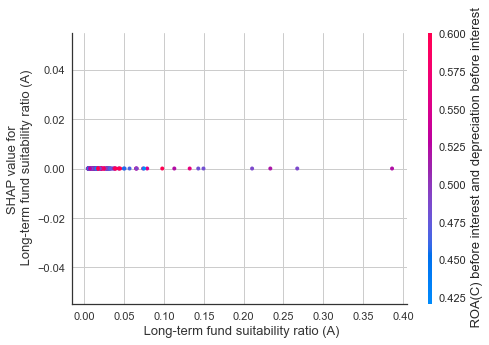

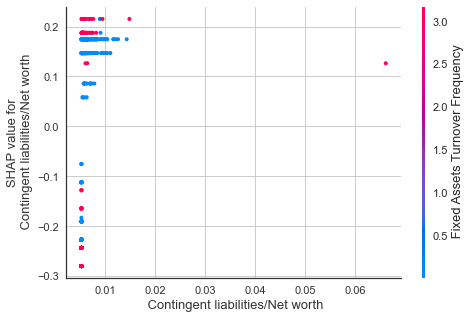

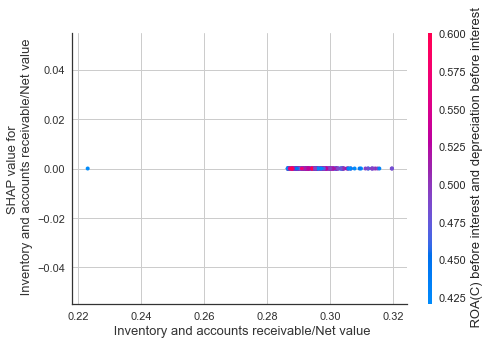

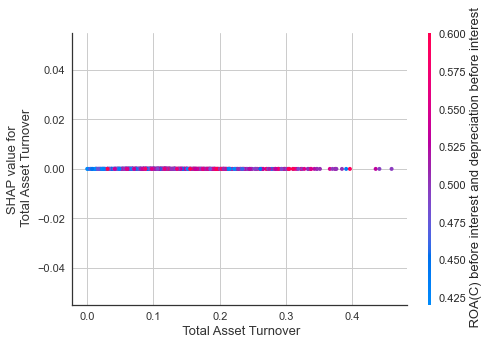

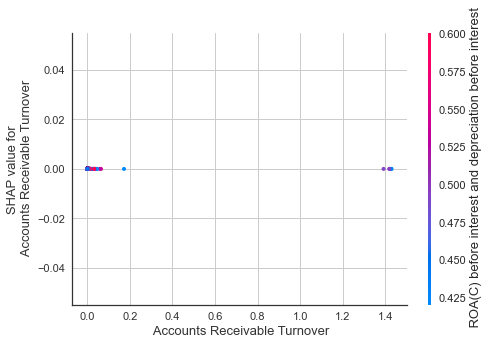

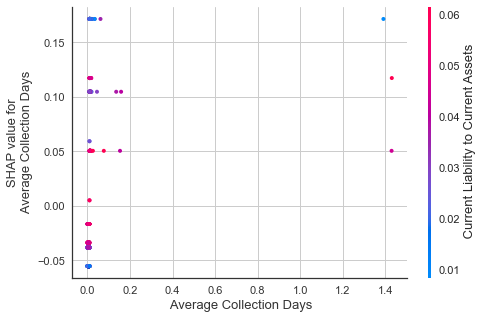

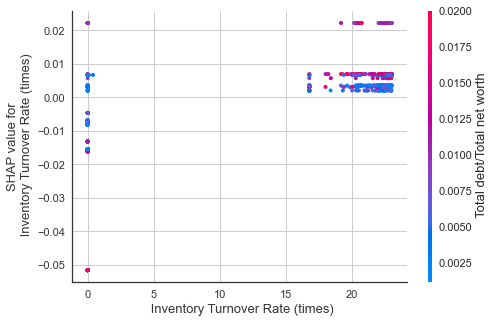

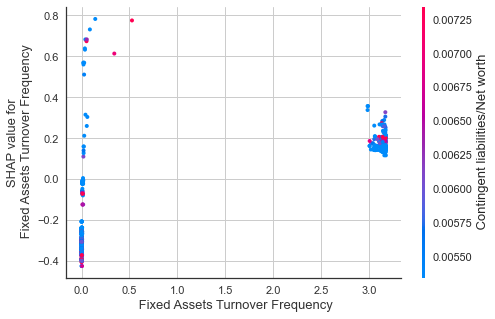

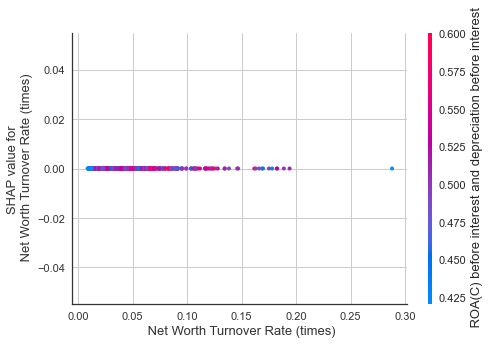

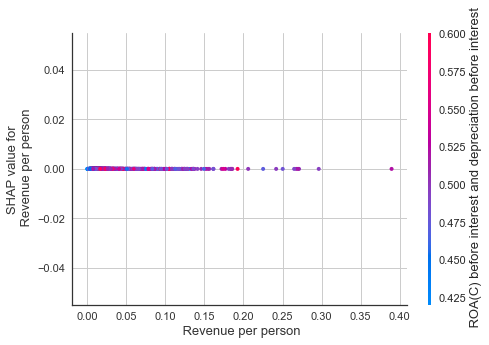

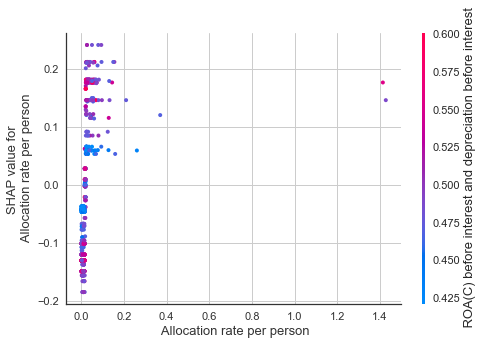

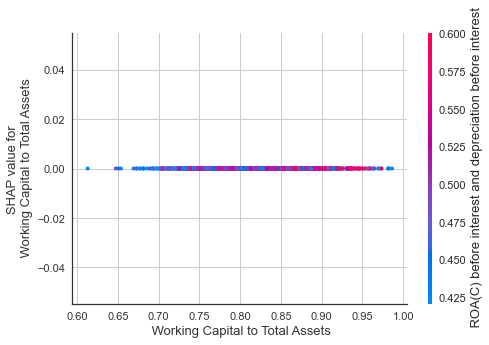

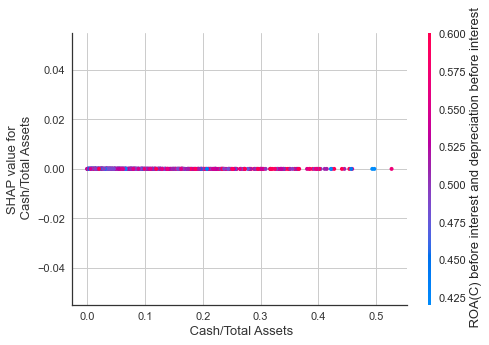

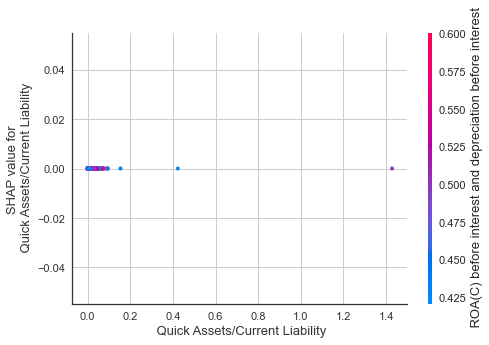

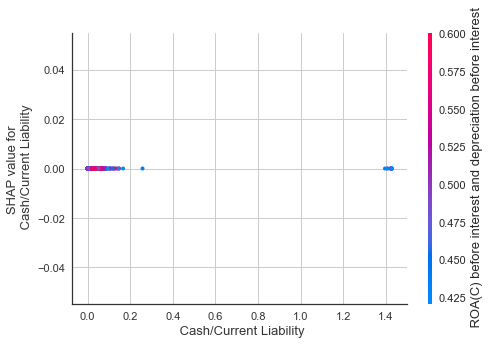

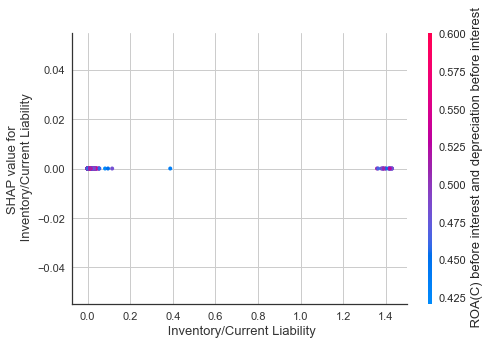

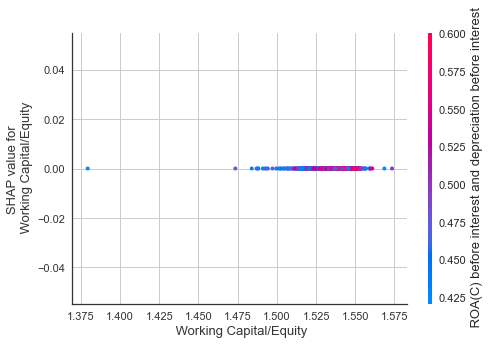

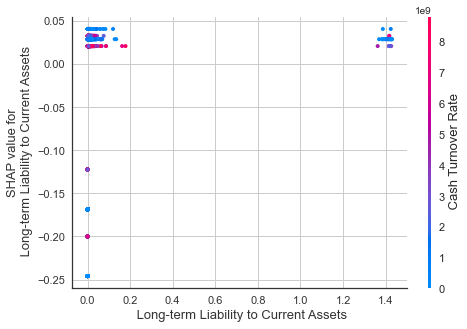

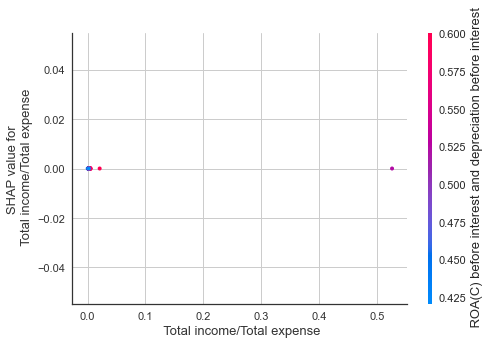

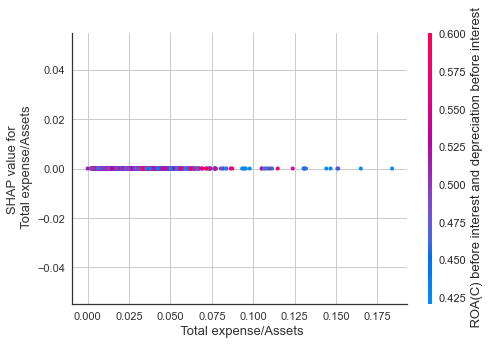

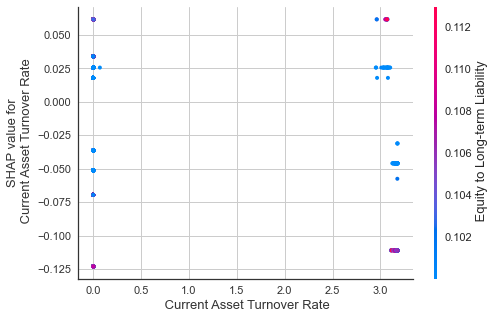

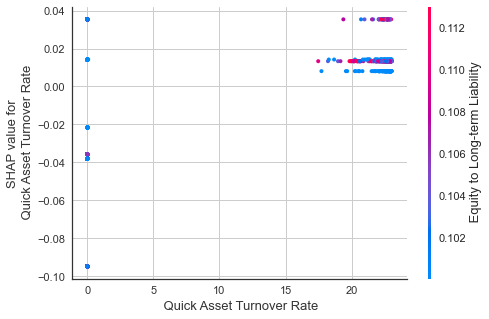

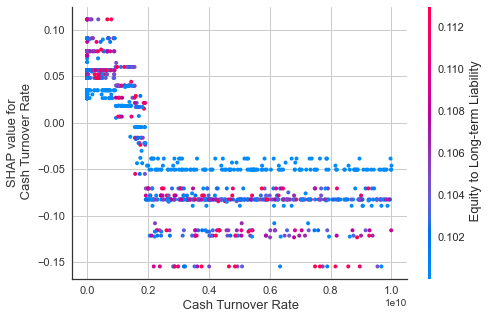

invalid value encountered in true_divide
invalid value encountered in true_divide


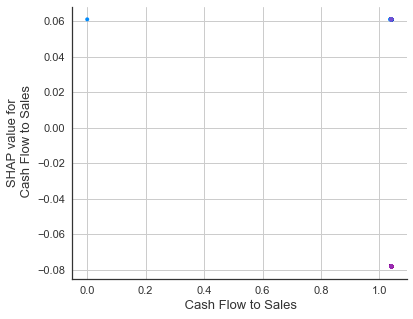

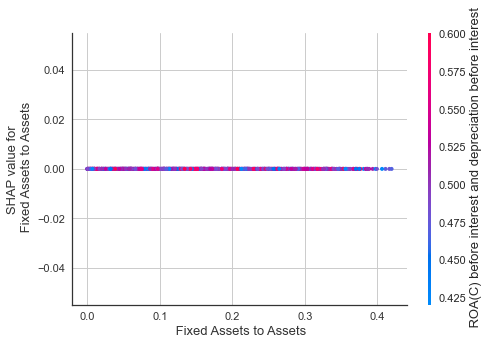

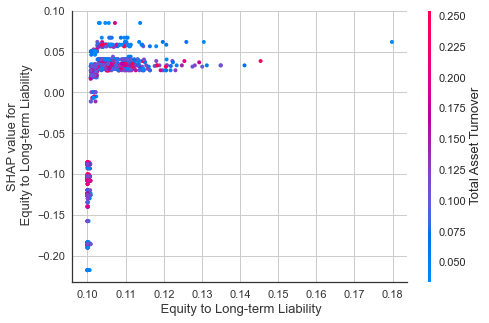

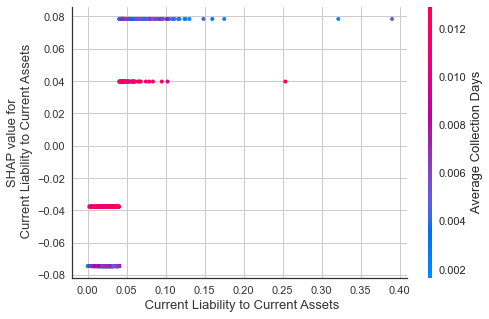

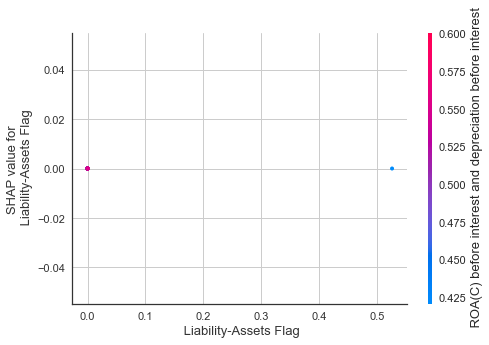

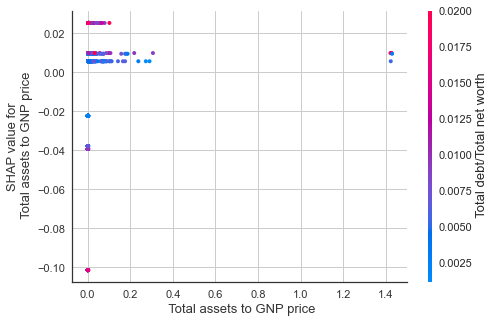

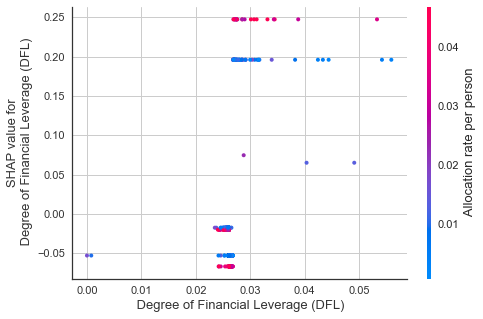

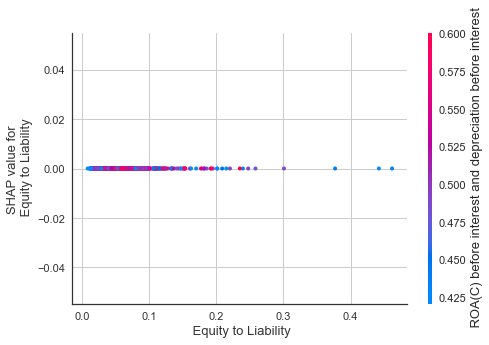

In [207]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)